In [18]:
%pip install opencv-python
%pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/165.0 kB ? eta -:--:--
     ------ ------------------------------ 30.7/165.0 kB 660.6 kB/s eta 0:00:01
     --------- --------------------------- 41.0/165.0 kB 495.5 kB/s eta 0:00:01
     ------------------------ ----------- 112.6/165.0 kB 939.4 kB/s eta 0:00:01
     ------------------------------------ 165.0/165.0 kB 899.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
    --------------------------------------- 0.2/8.0 MB 10.2 MB/s eta 0:00:01
    --------------------------------------- 0.2/8.0 MB 5.8 MB/s eta 0:00:02
   -- ------------------------------------- 0.4/8.0 MB 4.4 MB/s eta 0:00:02
   --- ------------------------------------ 0.6/8.0 MB 4.8 MB/s eta 0:00:02
   ---- ---

In [43]:
from random import sample, shuffle
from time import time
import os
import cv2 as cv
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

dataset_path = "./dataset"

def load_images():
    object_dirs = os.listdir(dataset_path)
    print(object_dirs)

    dataset = {}
    dataset_train = {}
    dataset_test = {}

    for obj in object_dirs:
        dataset[obj] = os.listdir(os.path.join(dataset_path, obj))


    for obj, images in dataset.items():
        shuffle(images)
        split_point = int(0.9 * len(images))  # 90% for training
        dataset_train[obj] = images[:split_point]
        dataset_test[obj] = images[split_point:]
    
    return dataset_train, dataset_test


def apply_sift(dataset):
    sift = cv.SIFT_create(nfeatures=200, edgeThreshold=4)

    dataset_sift = {}
    print(f"Processing SIFT...")
    for obj, images in dataset.items():
        dataset_sift[obj] = []
        for img in images:
            img_path = os.path.join(dataset_path, obj, img)
            img = cv.imread(img_path)
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            keypoints, descriptors = sift.detectAndCompute(gray, None)
            dataset_sift[obj].append((img, keypoints, descriptors ))

    return dataset_sift

def apply_orb(dataset):
    orb = cv.ORB_create(nfeatures=200, edgeThreshold=15,scaleFactor=1.3)
    dataset_orb = {}
    print(f"Processing ORB...")
    for obj, images in dataset.items():
        dataset_orb[obj] = []
        for img_name in images:
            img_path = os.path.join(dataset_path, obj, img_name)
            img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
            if img is None:
                continue
            keypoints, descriptors = orb.detectAndCompute(img, None)
            dataset_orb[obj].append((img, keypoints, descriptors))

    return dataset_orb

def apply_kaze(dataset):
    kaze = cv.KAZE_create(threshold=0.00001)
    dataset_kaze = {}

    print(f"Processing KAZE...")
    for obj, images in dataset.items():
        dataset_kaze[obj] = []
        for img_name in images:
            img_path = os.path.join(dataset_path, obj, img_name)
            img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
            if img is None:
                continue
            keypoints, descriptors = kaze.detectAndCompute(img, None)
            dataset_kaze[obj].append((img, keypoints, descriptors))

    return dataset_kaze



def show_few_keypoints(data, num_instances=6, images_per_row=3, algortihm="SIFT"):
    for obj, features in data.items():
        rows = (num_instances + images_per_row - 1) // images_per_row  # Calculate the number of rows needed
        plt.figure(figsize=(20, 5 * rows))
        plt.suptitle(f"{algortihm} Keypoints for {obj}", fontsize=20)
        
        for i in range(min(num_instances, len(features))):
            img, keypoints, _ = features[i]
            img_with_keypoints = cv.drawKeypoints(img, keypoints, None)
            
            plt.subplot(rows, images_per_row, i + 1)
            plt.imshow(img_with_keypoints, cmap='gray')
            plt.title(f"Instance {i + 1}")
            plt.axis('off')
        
        plt.show()

def recognize_objects(train_data, test_data):

    bf = None
    bf = cv.BFMatcher()
    true_labels = []
    predicted_labels = []

    for test_obj, test_features in test_data.items():
        print(f"Recognizing objects in test set for {test_obj}:")
        for _, _, test_des in test_features:
            if test_des is None:
                continue
            
            matches_count = defaultdict(int)
            for train_obj in train_data.keys():
                matches_count[train_obj] = 0
            
            for train_obj, train_features in train_data.items():
                for _, _, train_des in train_features:
                    if train_des is None:
                        continue
                    
                    matches = bf.knnMatch(test_des, train_des, k=2)
                    try:
                        good_matches = [m for m, n in matches if m.distance < 0.45 * n.distance]
                    except:
                        good_matches = []
                    
                    matches_count[train_obj] += len(good_matches)
            
            recognized_obj = max(matches_count, key=matches_count.get)
            true_labels.append(test_obj)
            predicted_labels.append(recognized_obj)
            # print(f"Test image recognized as {recognized_obj}")

    return true_labels, predicted_labels


def show_confusion_matrix(true_labels, predicted_labels, method):
    labels = sorted(list(set(true_labels)))
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    # Calculate accuracy
    accuracy = (cm.diagonal().sum() / cm.sum()) * 100
    
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {method.upper()} (Accuracy: {accuracy:.2f}%)')
    plt.show()


def train_with_sift(dataset_train, dataset_test):    
    start_time = time()

    dataset_train_sift = apply_sift(dataset_train)
    dataset_test_sift = apply_sift(dataset_test)
    true_labels, predicted_labels = recognize_objects(dataset_train_sift, dataset_test_sift)

    end_time = time()
    execution_time = end_time - start_time
    print(f"Execution time of SIFT: {execution_time} seconds")


    show_confusion_matrix(true_labels, predicted_labels, method="SIFT")
    show_few_keypoints(dataset_train_sift)



def train_with_orb(dataset_train, dataset_test):    
    start_time = time()

    dataset_train_orb = apply_orb(dataset_train)
    dataset_test_orb = apply_orb(dataset_test)
    true_labels, predicted_labels = recognize_objects(dataset_train_orb, dataset_test_orb)
    
    end_time = time()
    execution_time = end_time - start_time
    print(f"Execution time of ORB: {execution_time} seconds")


    show_confusion_matrix(true_labels, predicted_labels, method="ORB")
    show_few_keypoints(dataset_train_orb, algortihm="ORB")


def train_with_kaze(dataset_train, dataset_test):    
    start_time = time()
    
    dataset_train_kaze = apply_kaze(dataset_train)
    dataset_test_kaze = apply_kaze(dataset_test)
    true_labels, predicted_labels = recognize_objects(dataset_train_kaze, dataset_test_kaze)

    end_time = time()
    execution_time = end_time - start_time
    print(f"Execution time of KAZE: {execution_time} seconds")

    show_confusion_matrix(true_labels, predicted_labels, method="KAZE")
    show_few_keypoints(dataset_train_kaze, algortihm="KAZE")


In [44]:
dataset_train, dataset_test = load_images()





['cell_phone_4', 'dry_battery_4', 'food_can_4', 'glue_stick_4', 'marker_4', 'notebook_4', 'sponge_4', 'stapler_4', 'toothbrush_4', 'water_bottle_4']


Processing SIFT...
Processing SIFT...
Recognizing objects in test set for cell_phone_4:
Recognizing objects in test set for dry_battery_4:
Recognizing objects in test set for food_can_4:
Recognizing objects in test set for glue_stick_4:
Recognizing objects in test set for marker_4:
Recognizing objects in test set for notebook_4:
Recognizing objects in test set for sponge_4:
Recognizing objects in test set for stapler_4:
Recognizing objects in test set for toothbrush_4:
Recognizing objects in test set for water_bottle_4:
Execution time of SIFT: 193.63440680503845 seconds


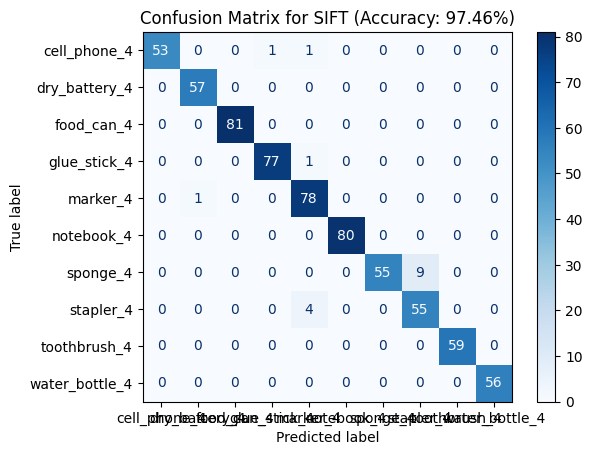

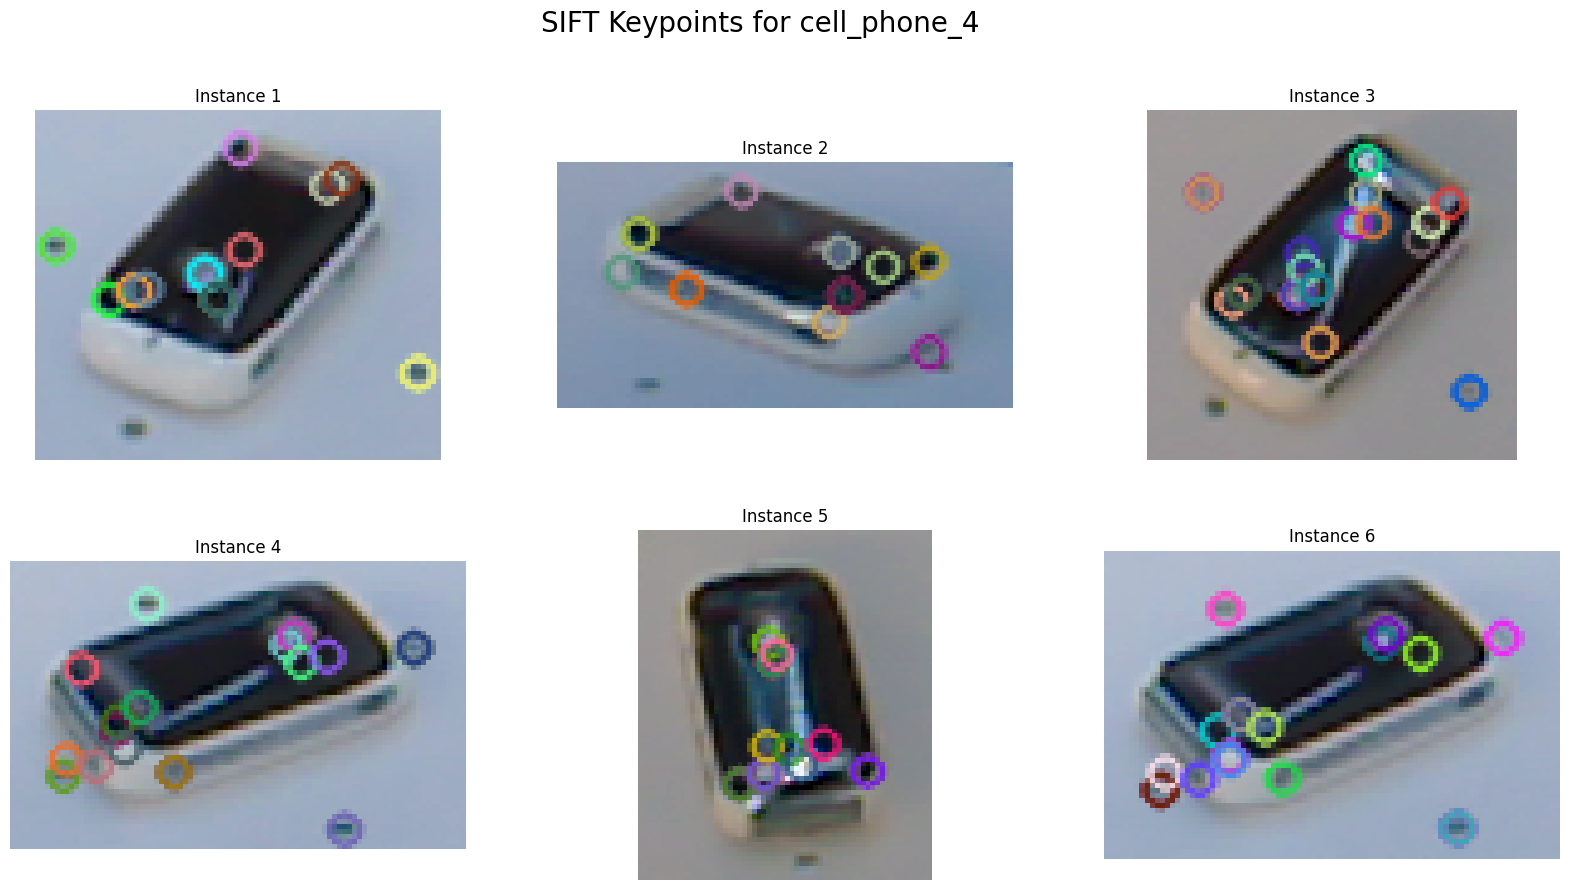

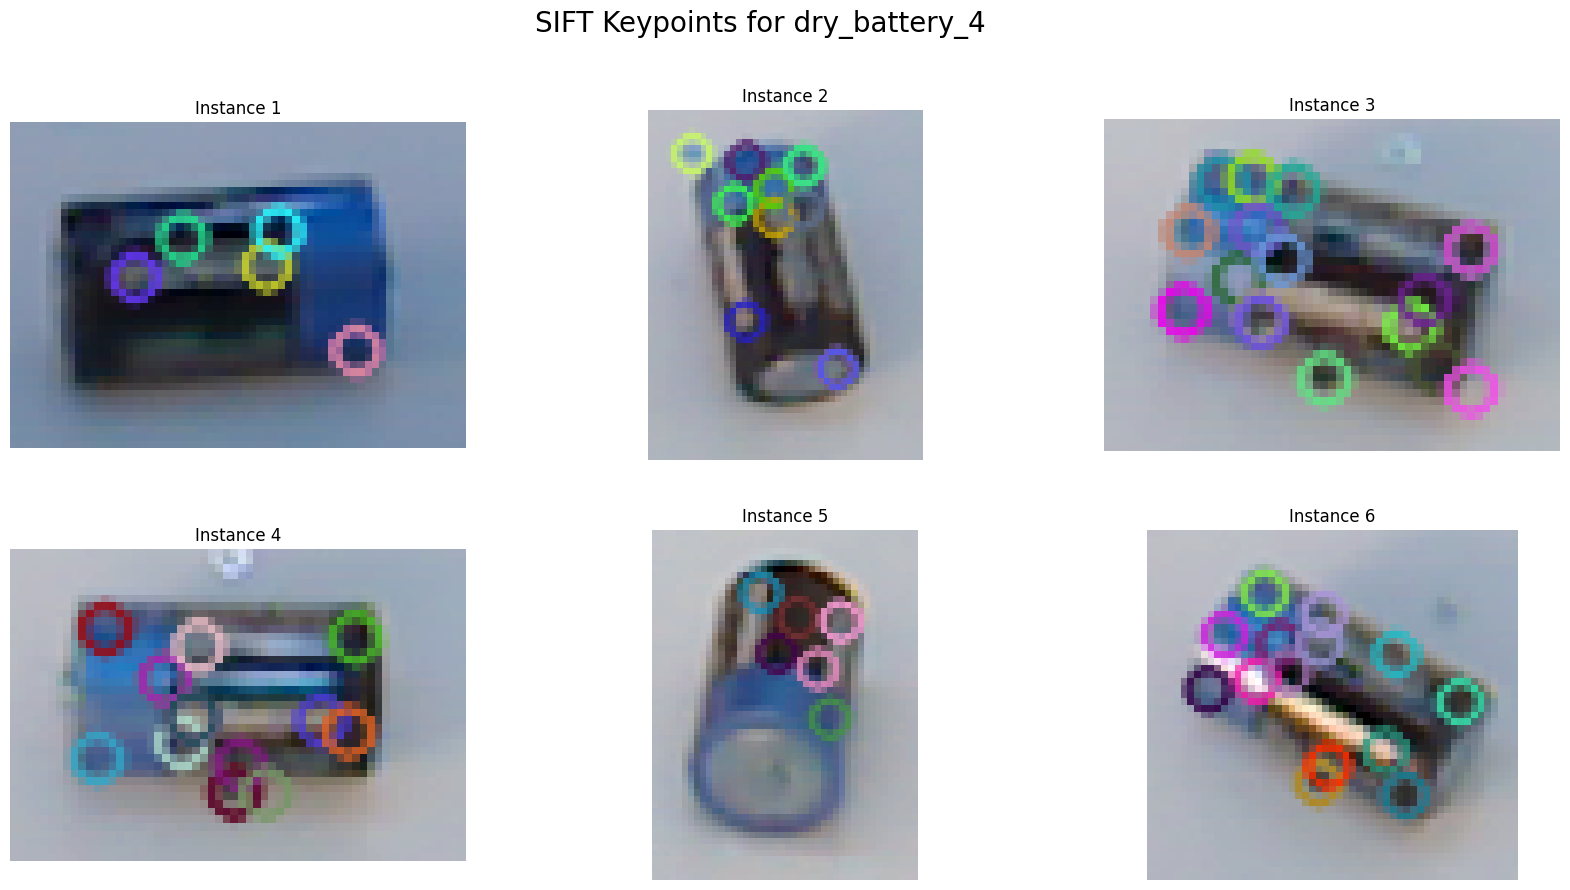

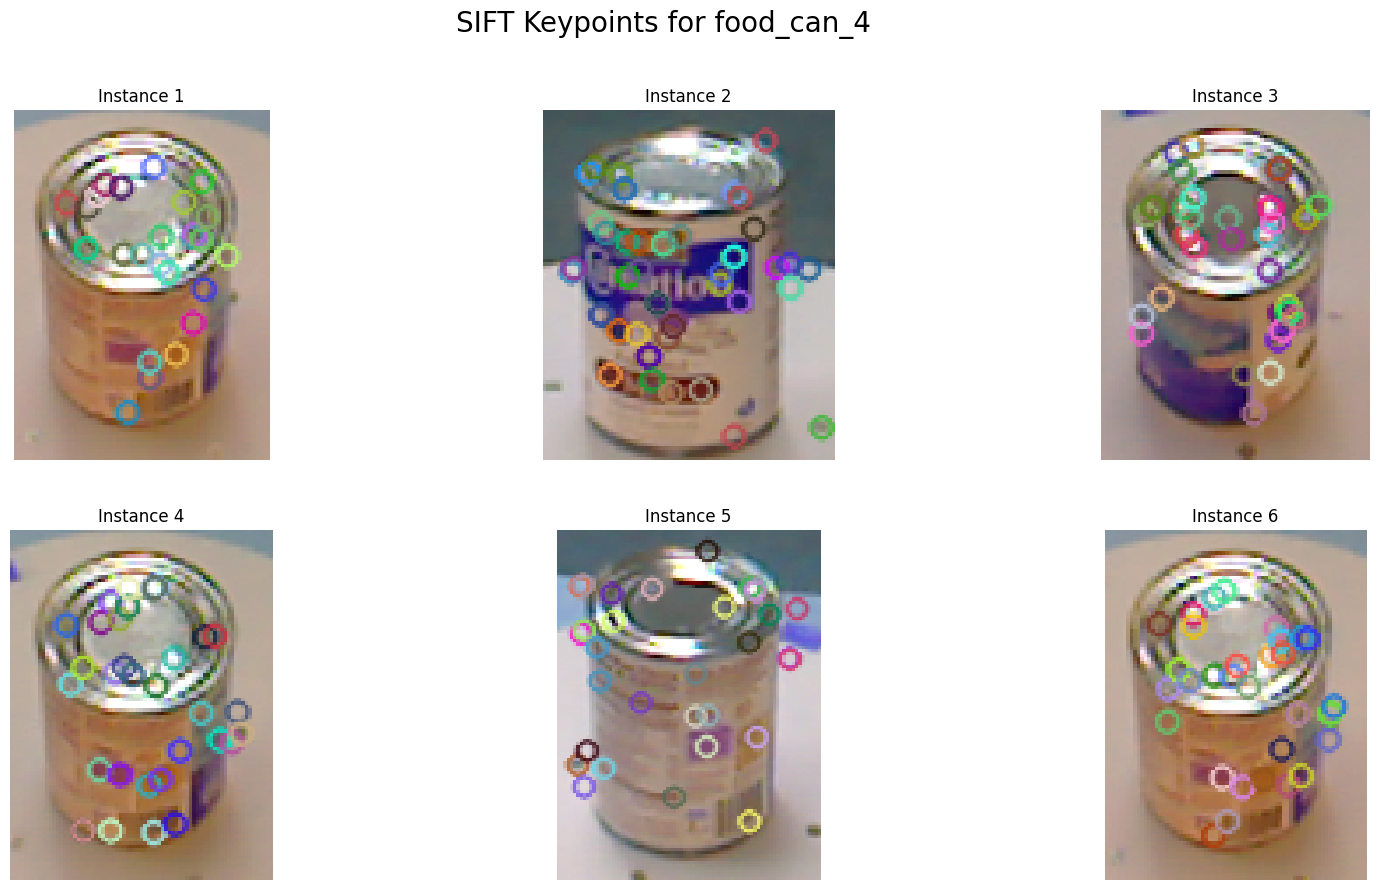

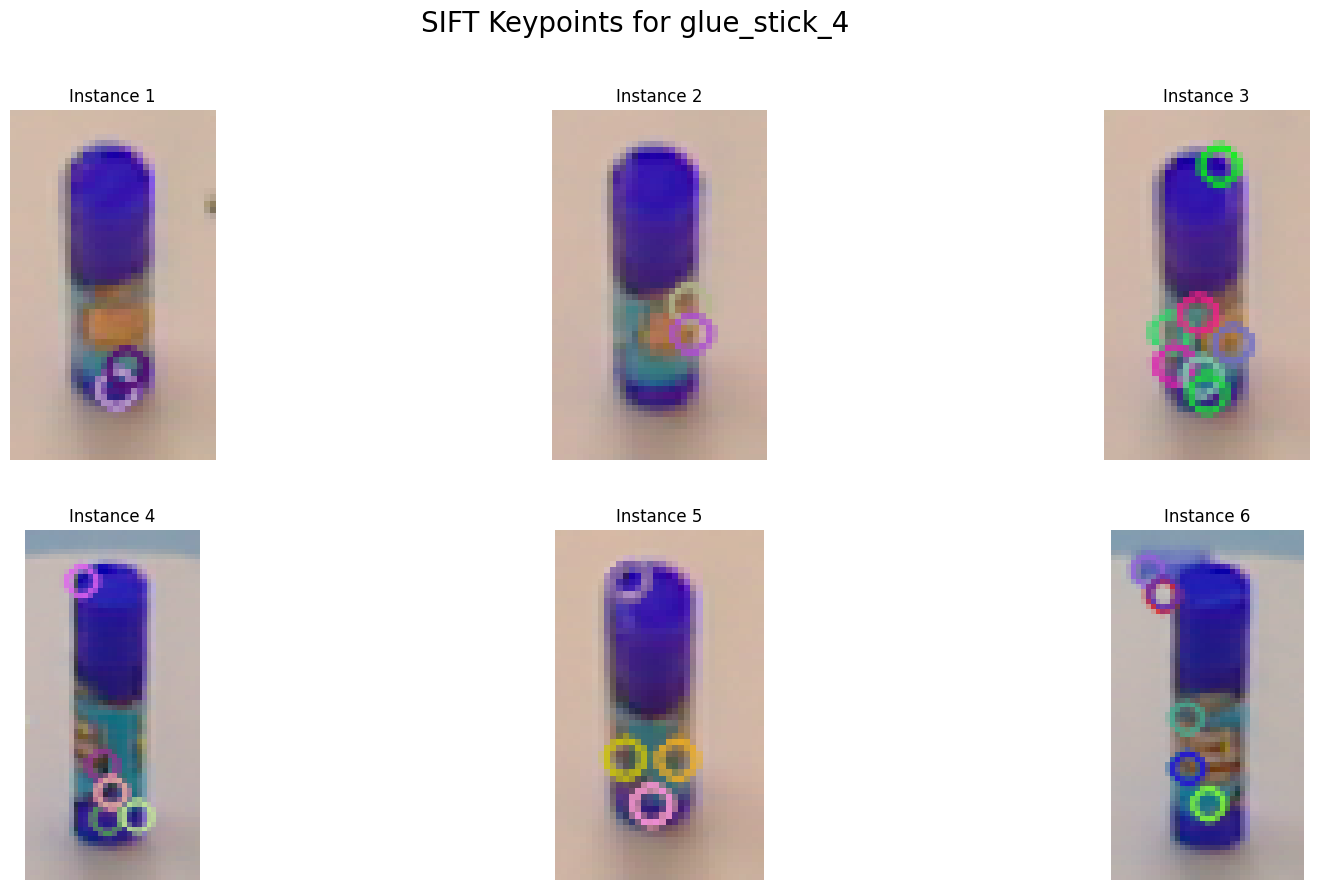

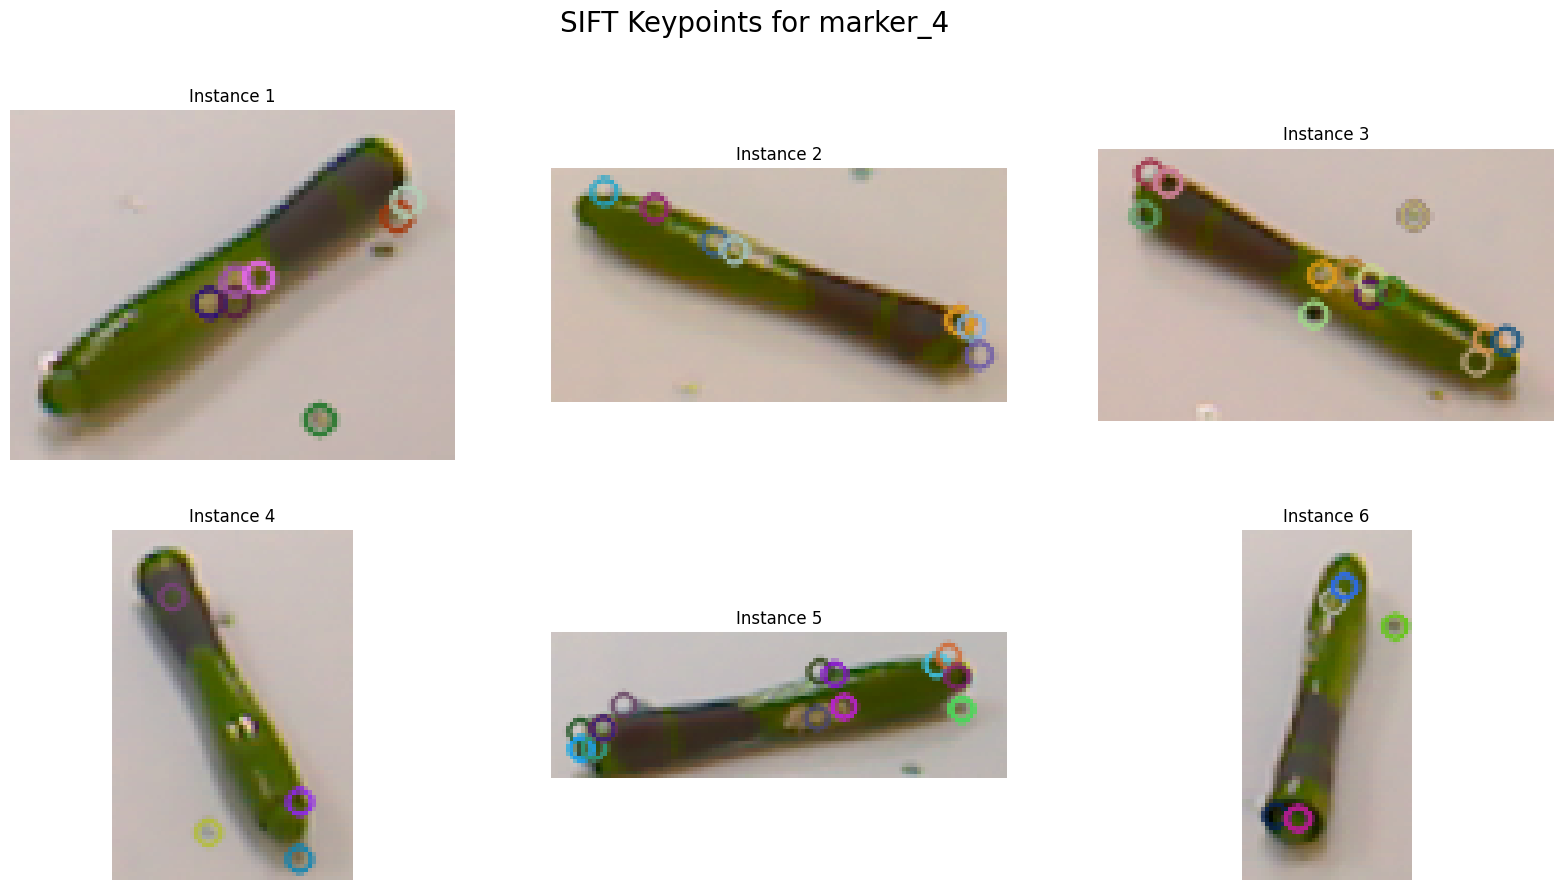

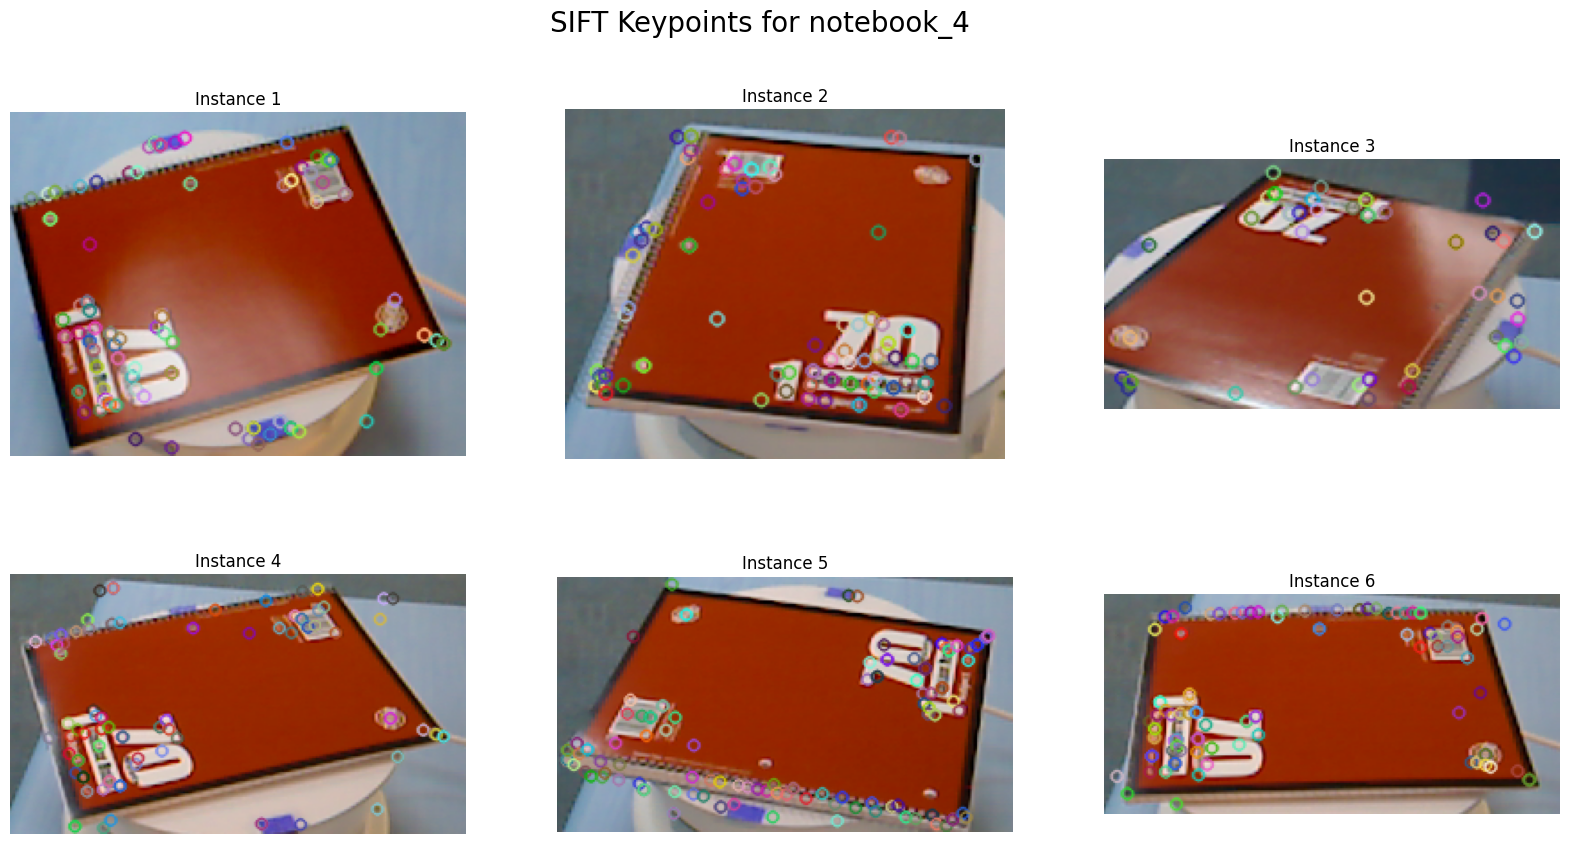

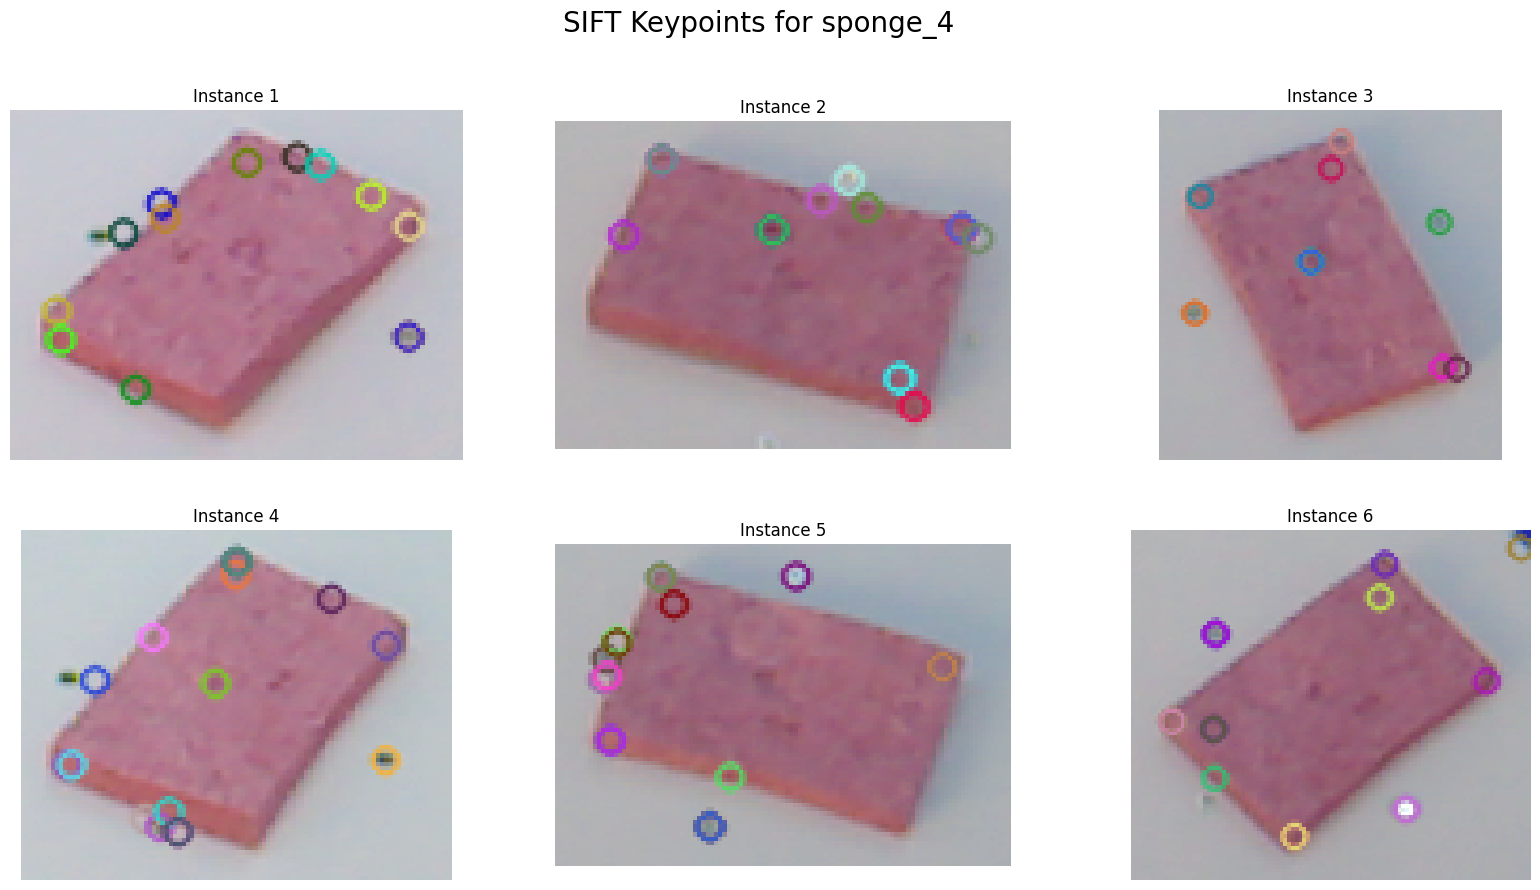

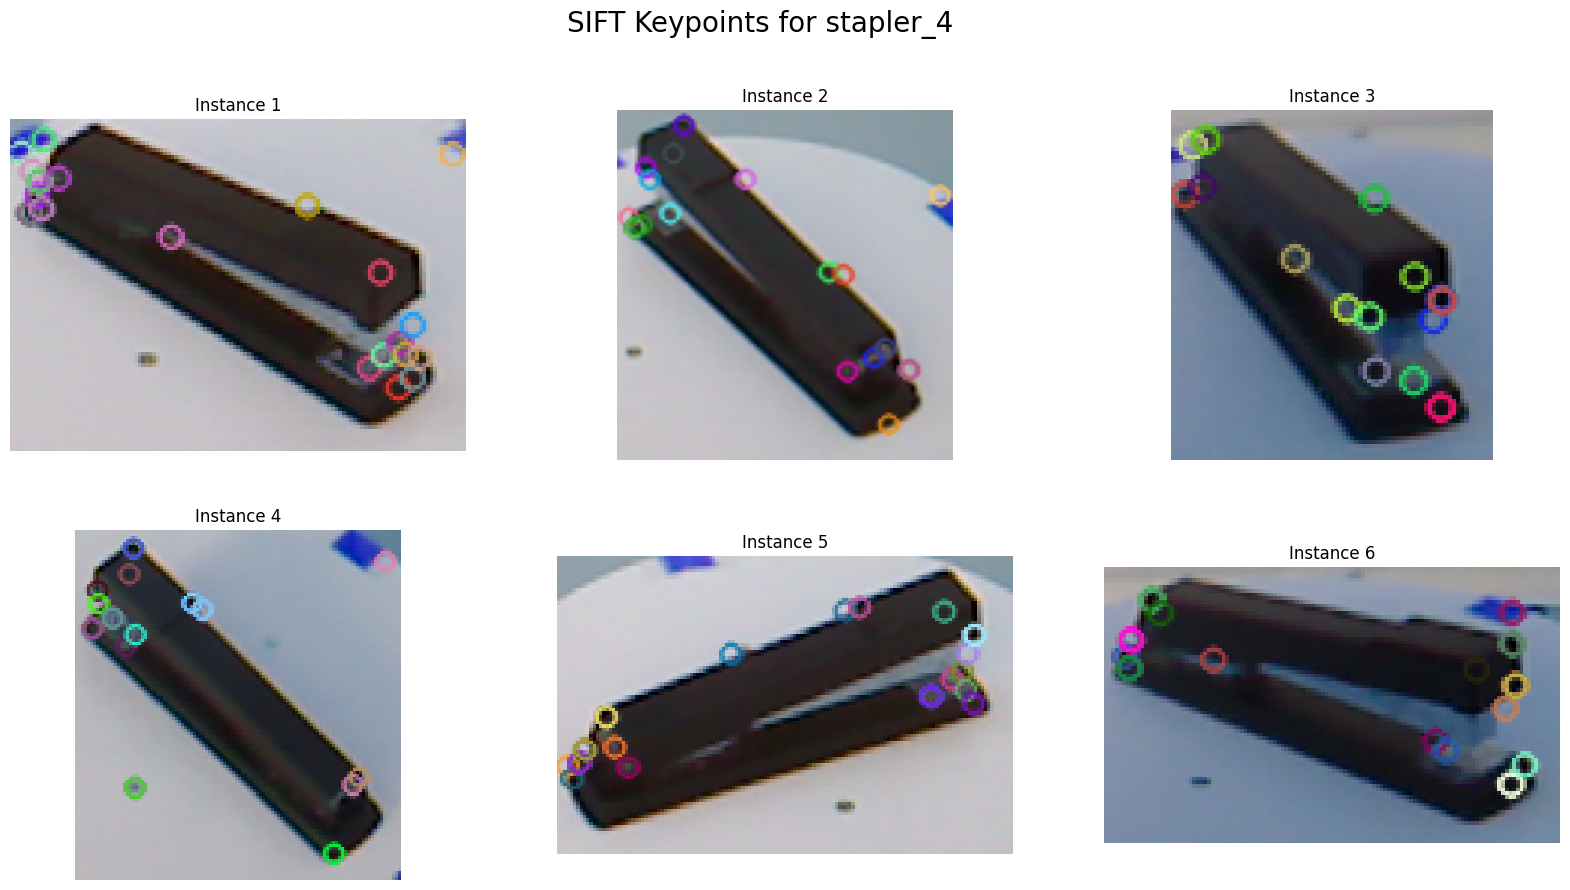

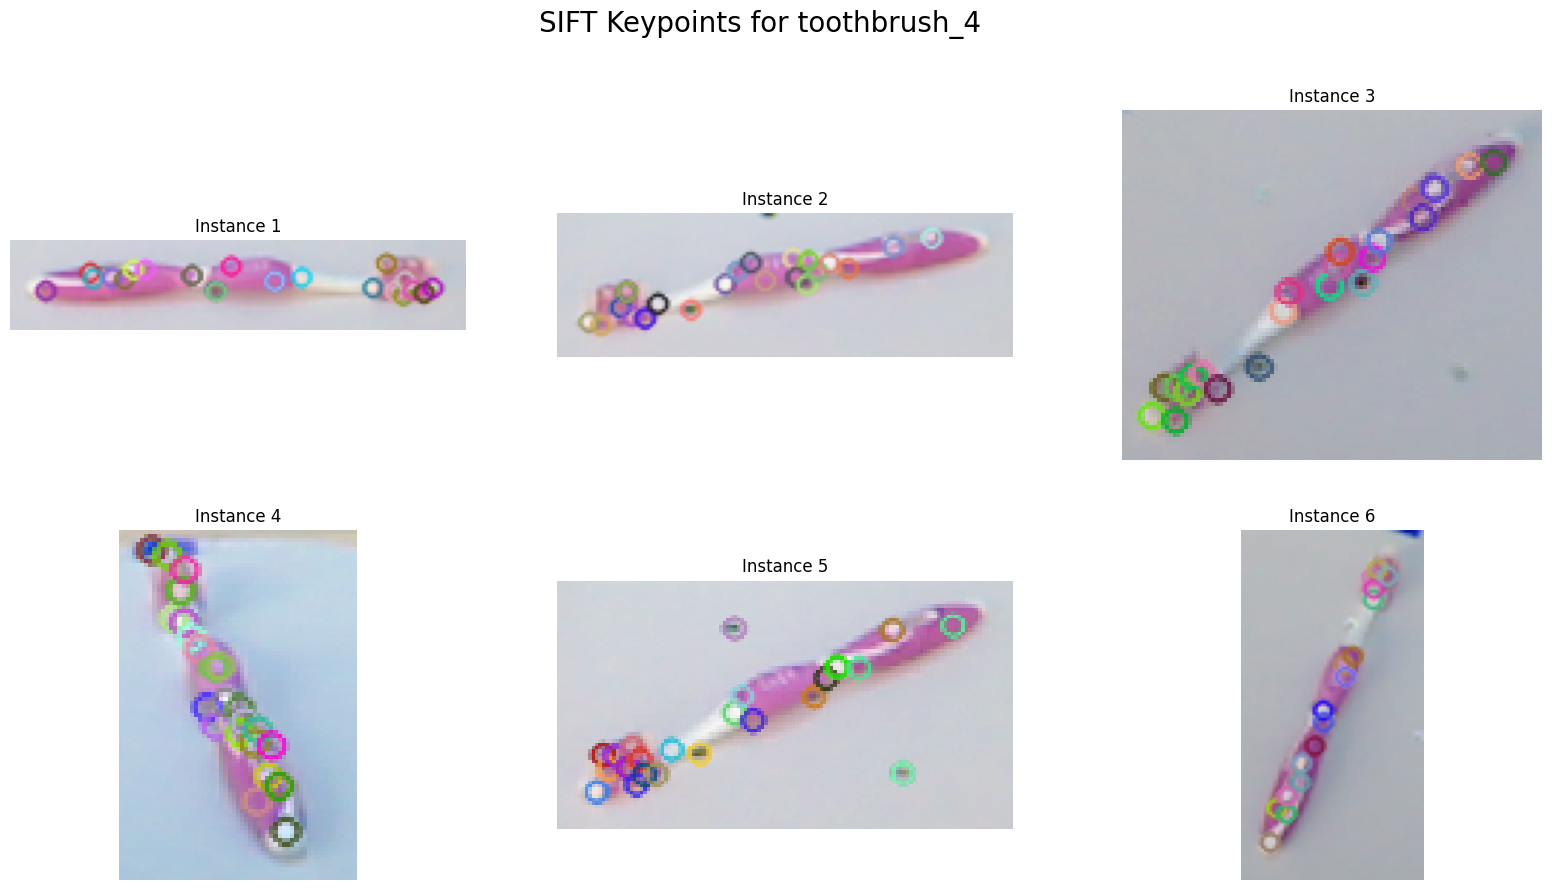

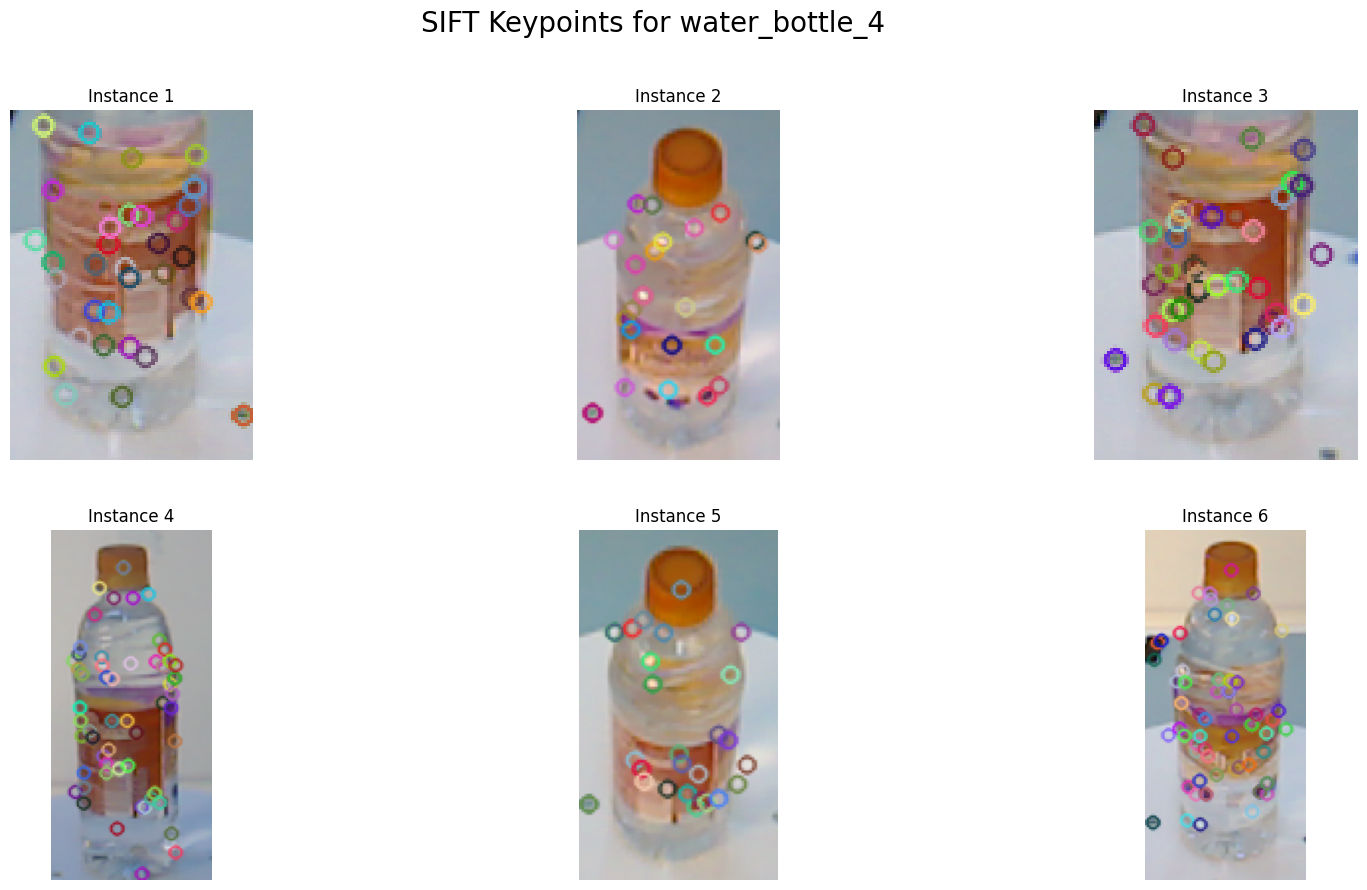

In [39]:
train_with_sift(dataset_train, dataset_test)



Processing ORB...
Processing ORB...
Recognizing objects in test set for cell_phone_4:
Recognizing objects in test set for dry_battery_4:
Recognizing objects in test set for food_can_4:
Recognizing objects in test set for glue_stick_4:
Recognizing objects in test set for marker_4:
Recognizing objects in test set for notebook_4:
Recognizing objects in test set for sponge_4:
Recognizing objects in test set for stapler_4:
Recognizing objects in test set for toothbrush_4:
Recognizing objects in test set for water_bottle_4:
Execution time of ORB: 272.3637025356293 seconds


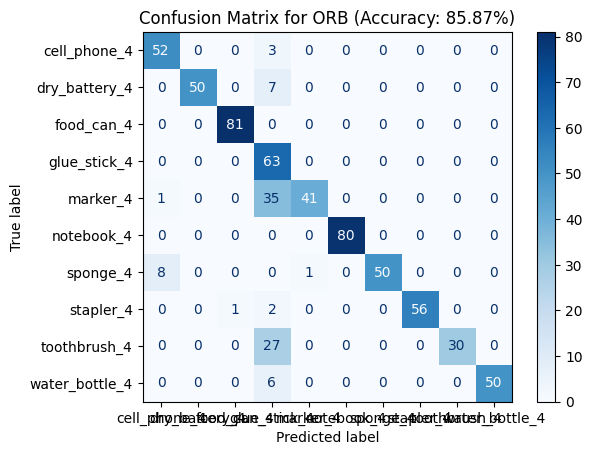

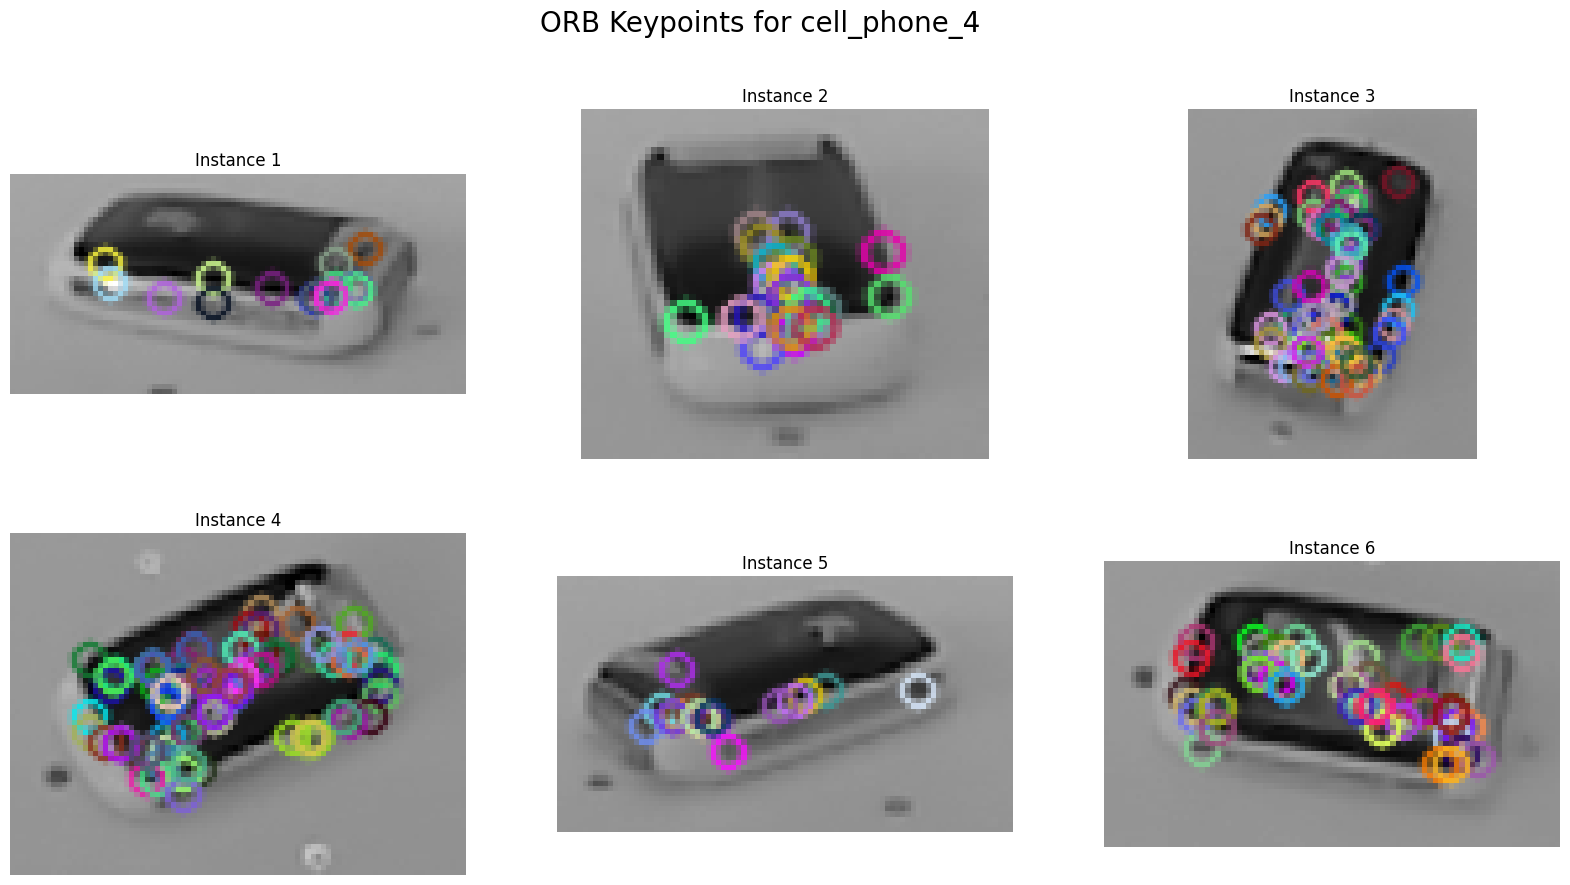

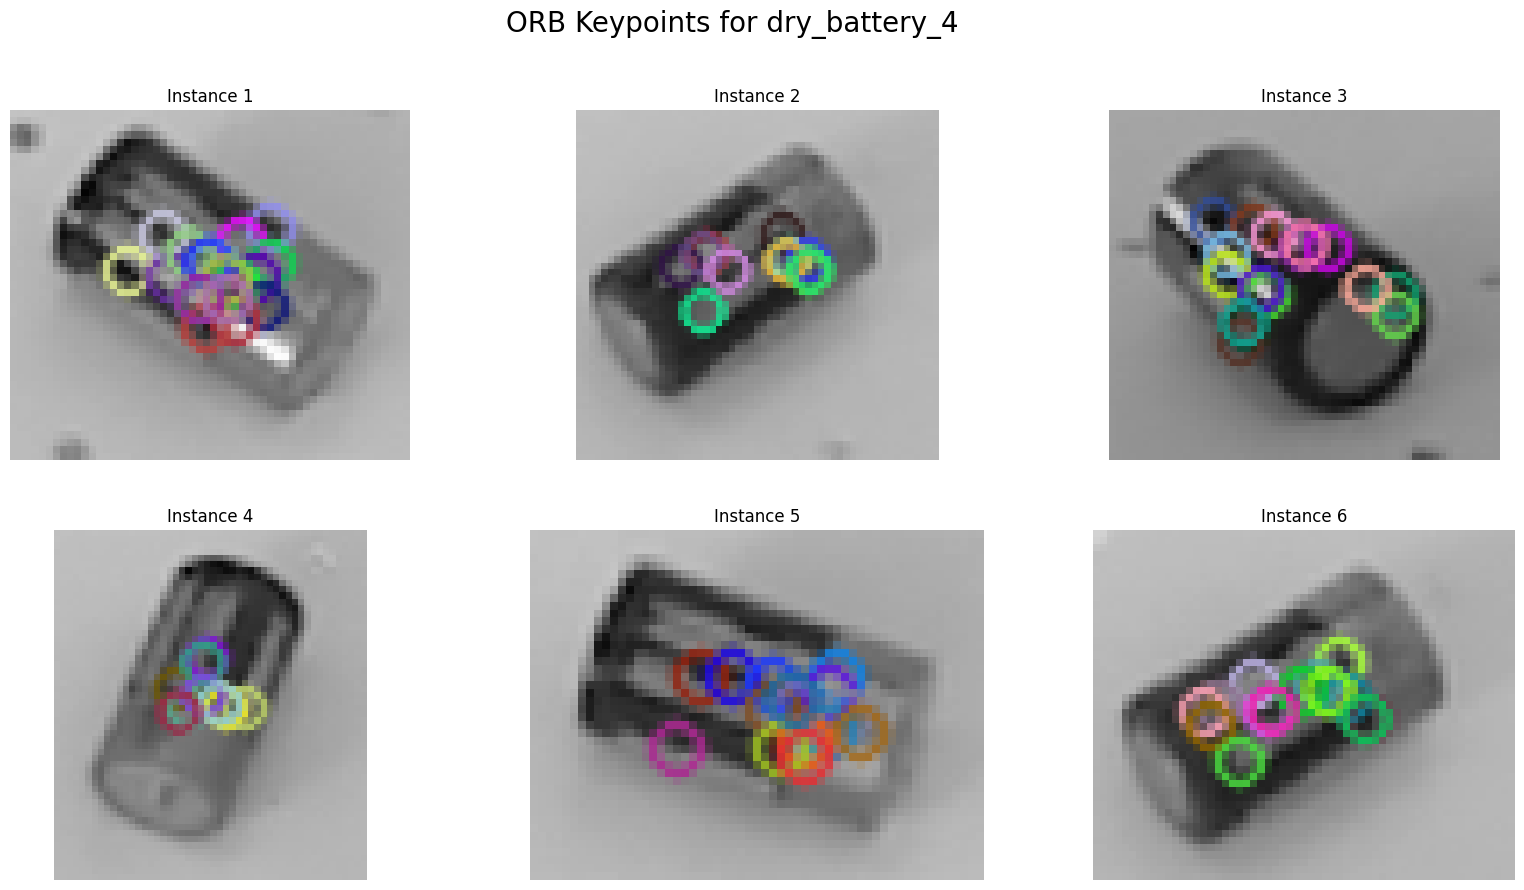

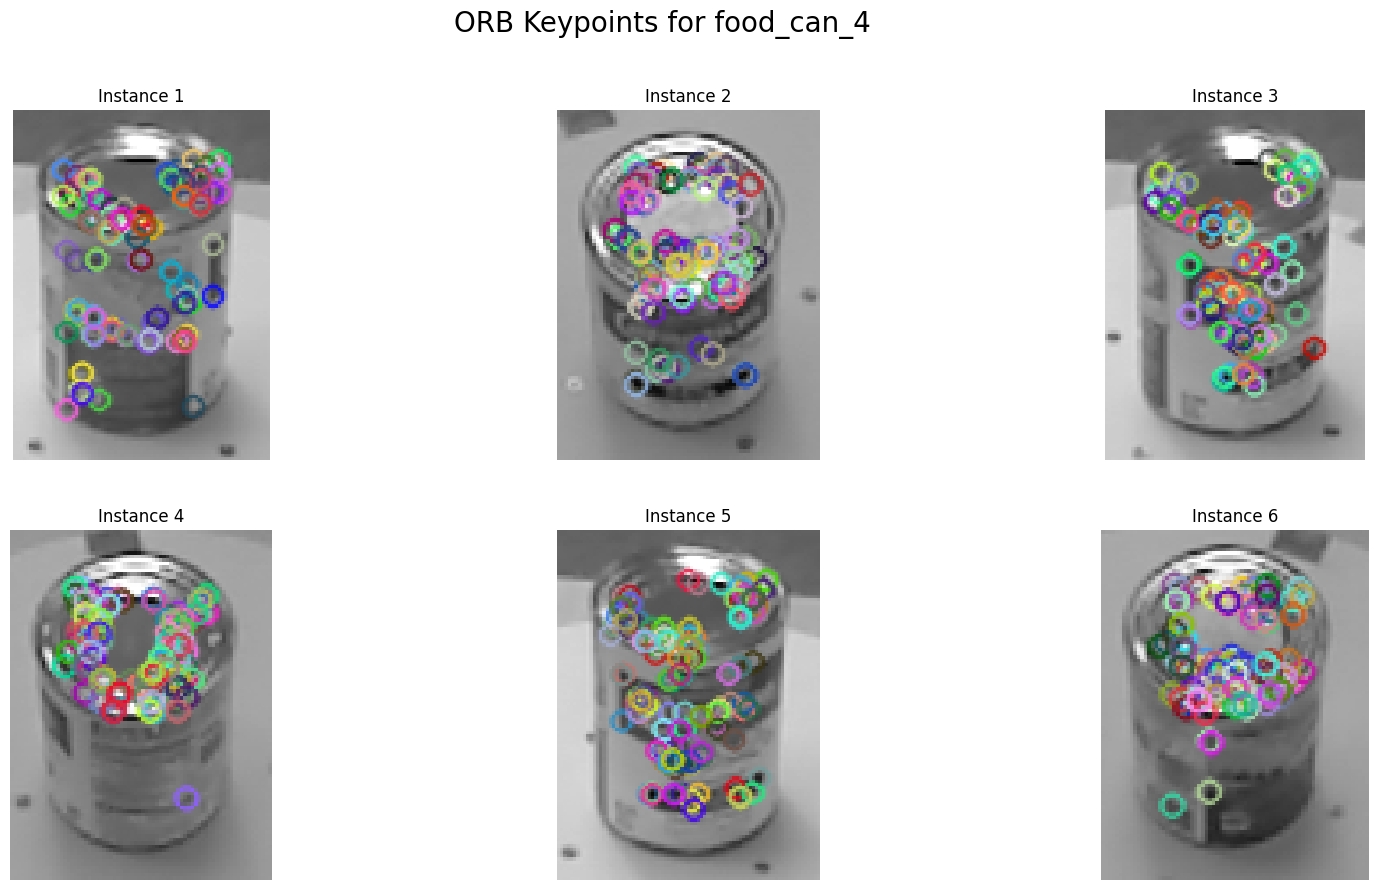

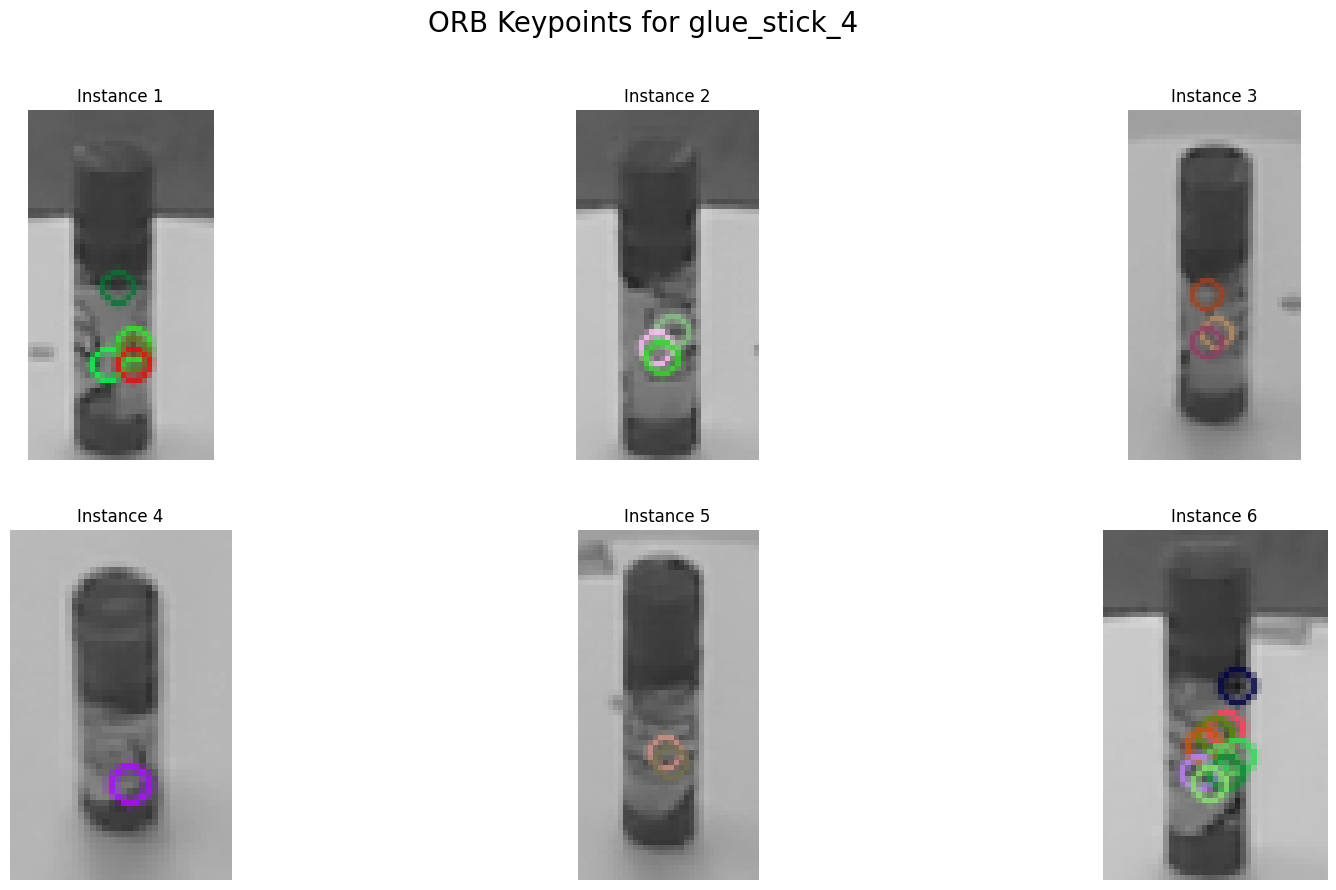

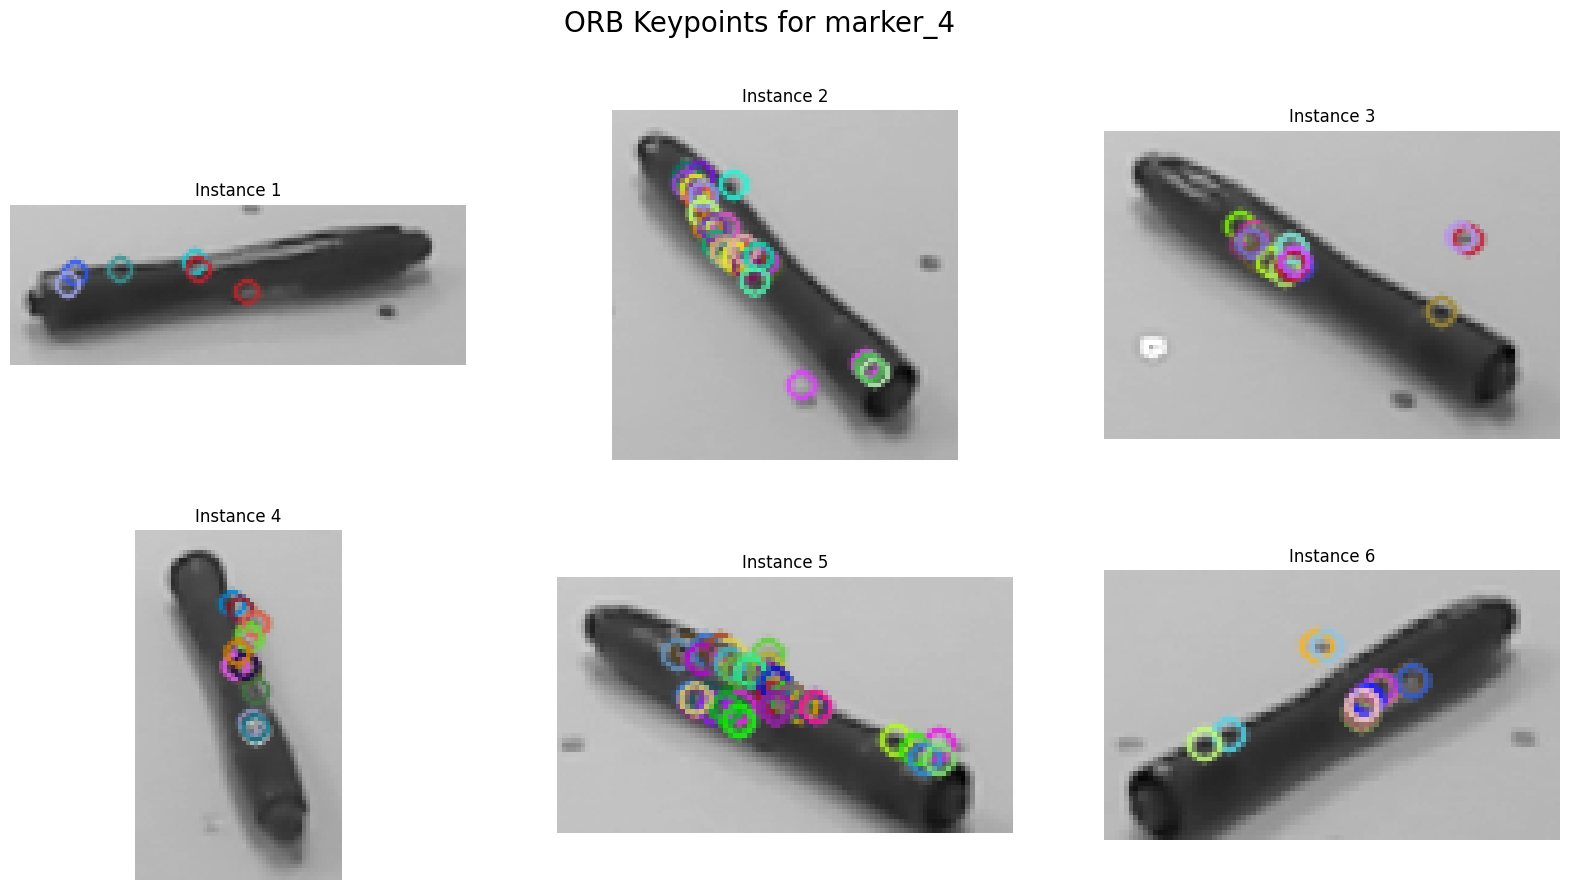

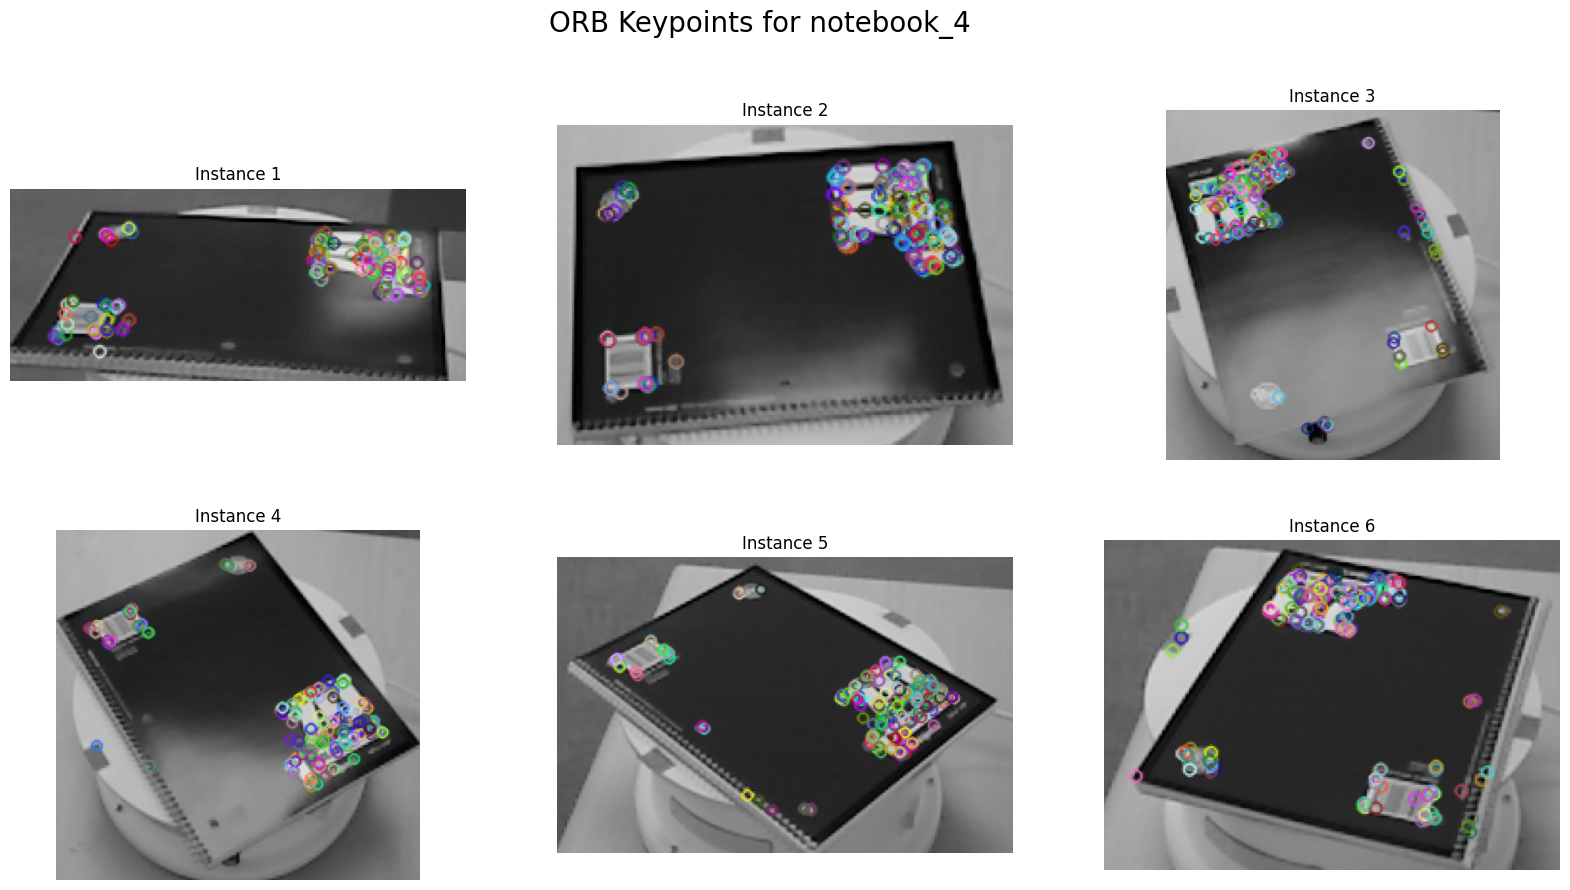

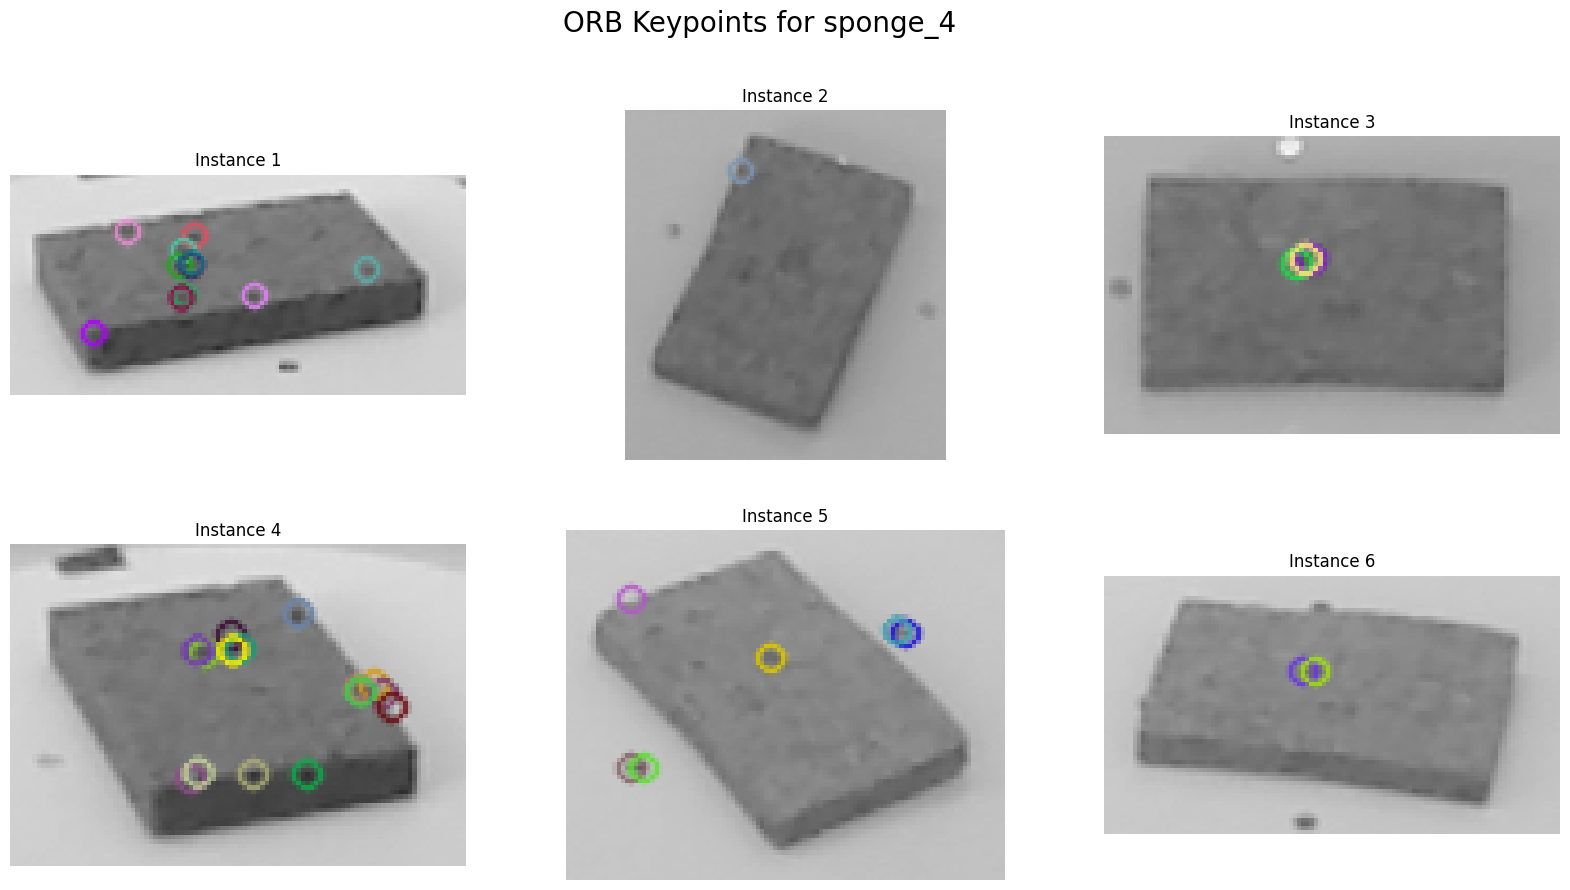

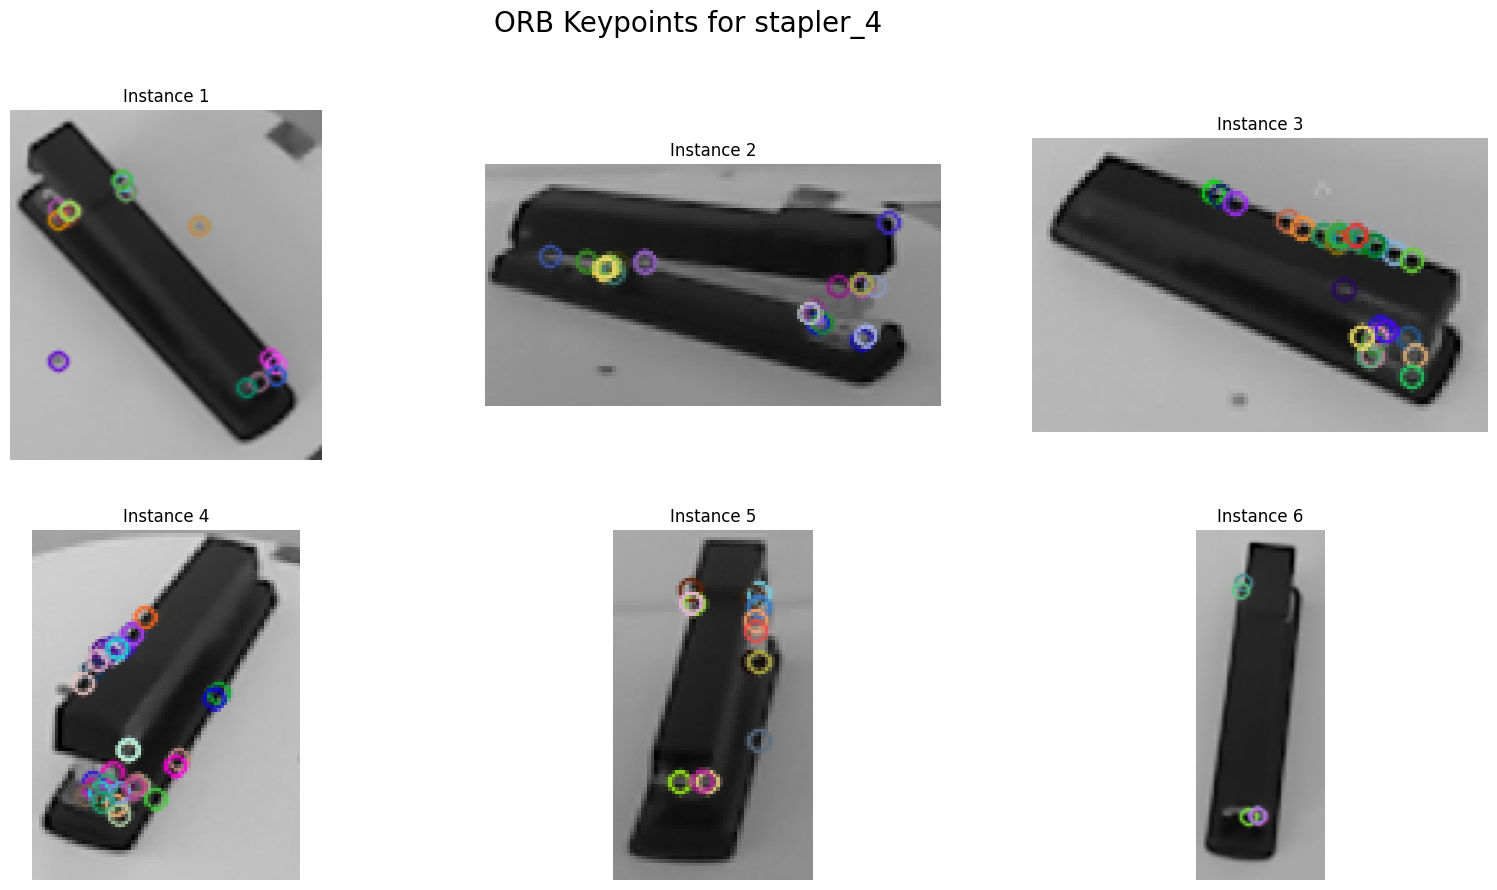

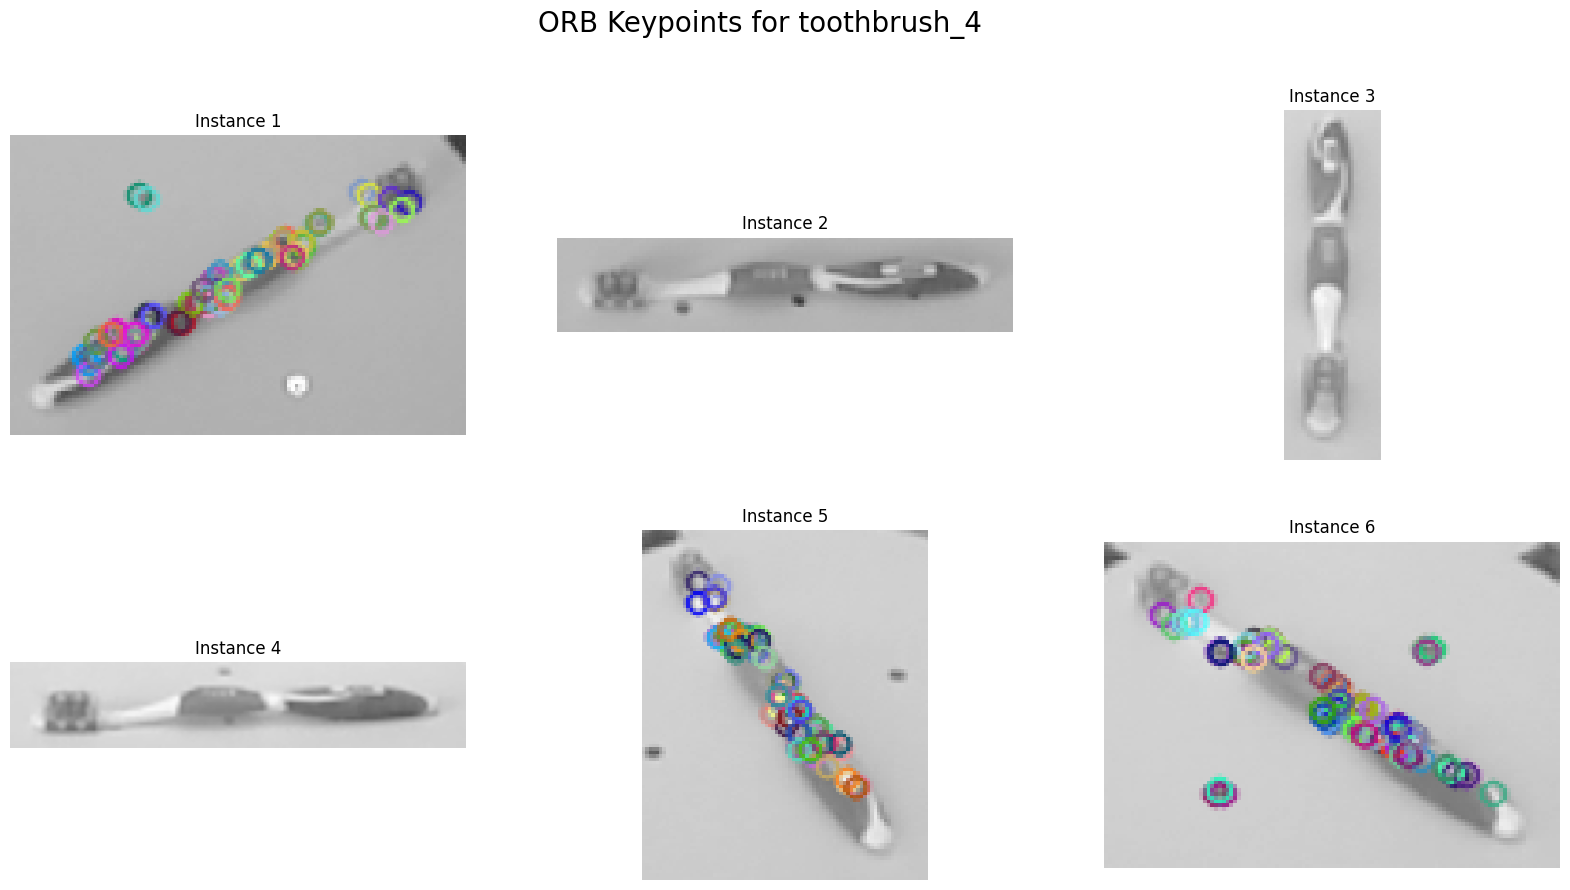

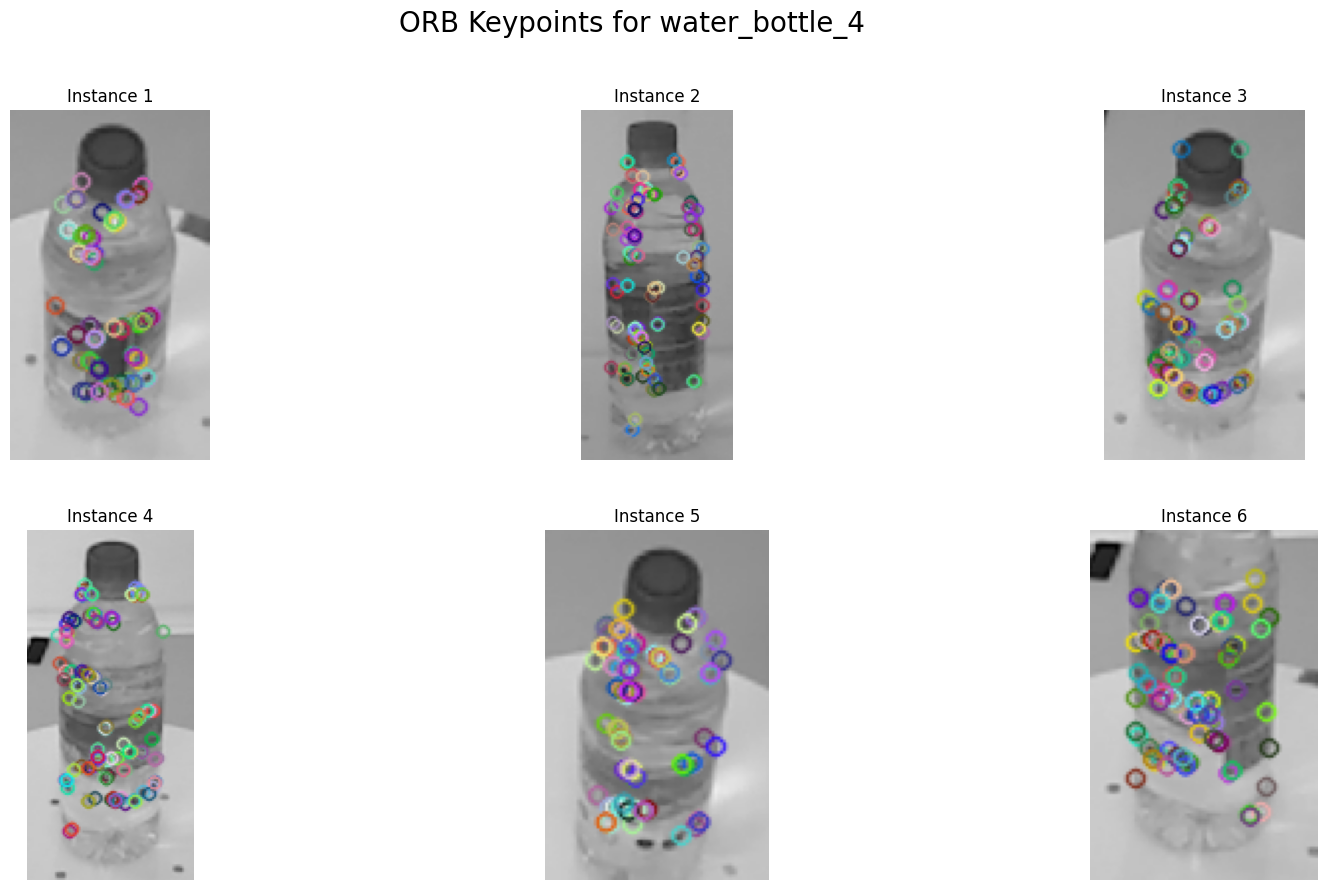

In [42]:
train_with_orb(dataset_train, dataset_test)

Processing KAZE...
Processing KAZE...
Recognizing objects in test set for cell_phone_4:
Recognizing objects in test set for dry_battery_4:
Recognizing objects in test set for food_can_4:
Recognizing objects in test set for glue_stick_4:
Recognizing objects in test set for marker_4:
Recognizing objects in test set for notebook_4:
Recognizing objects in test set for sponge_4:
Recognizing objects in test set for stapler_4:
Recognizing objects in test set for toothbrush_4:
Recognizing objects in test set for water_bottle_4:
Execution time of KAZE: 806.256411075592 seconds


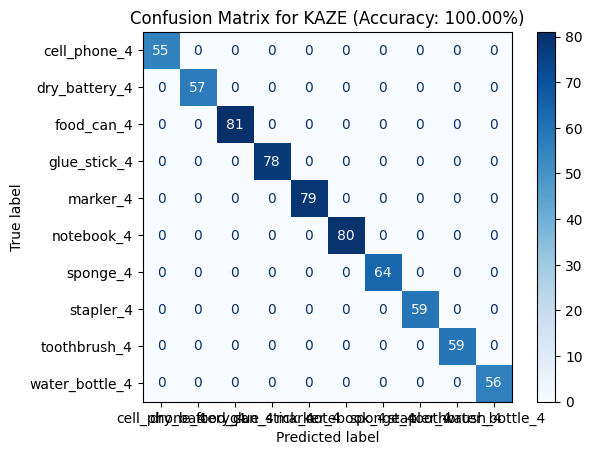

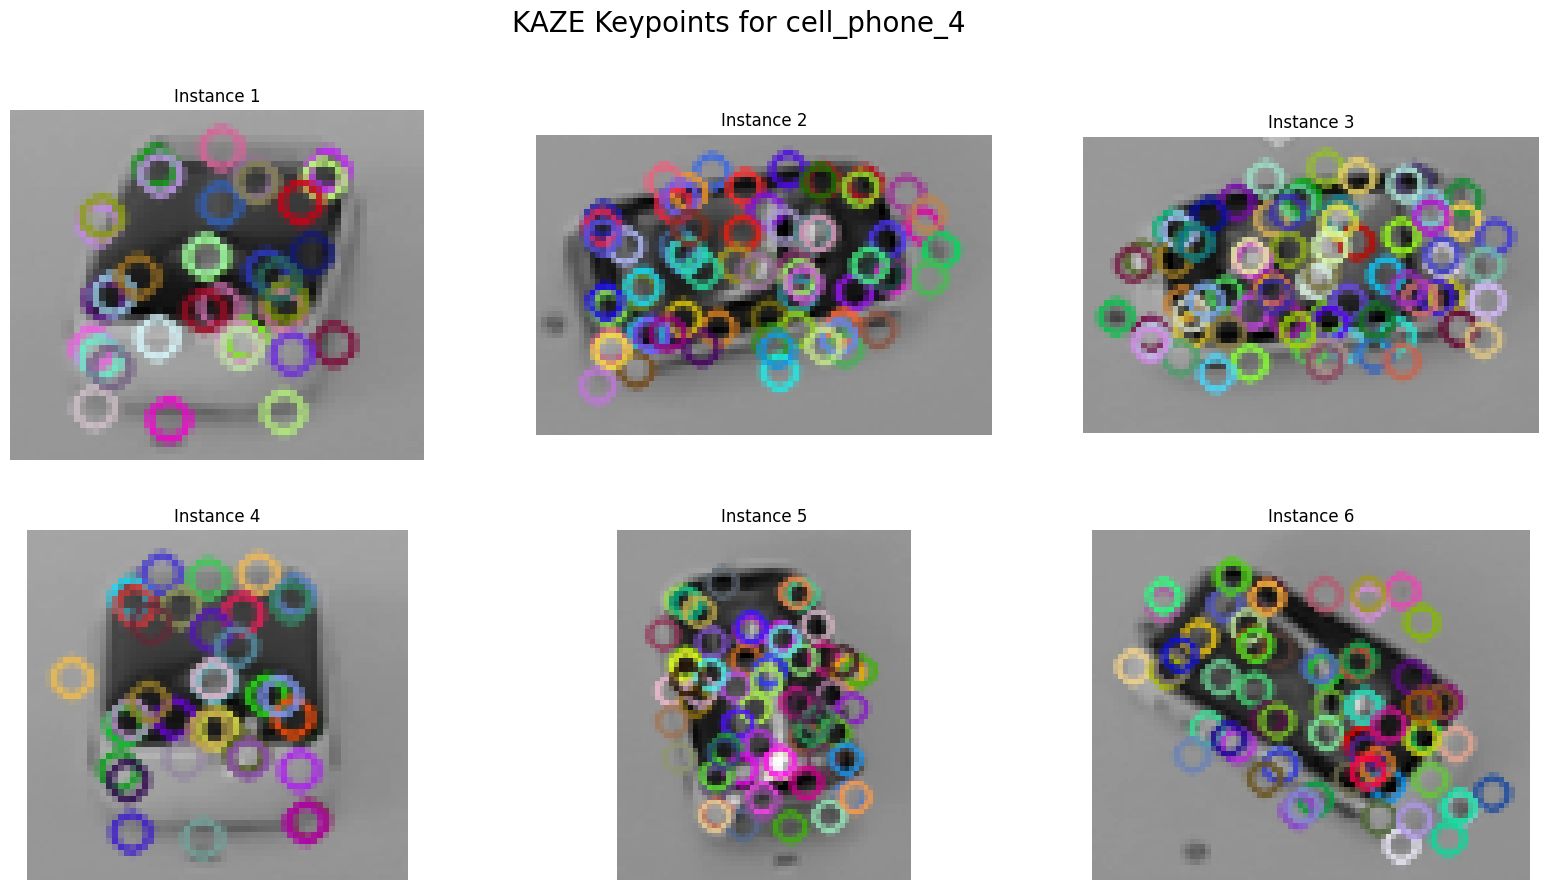

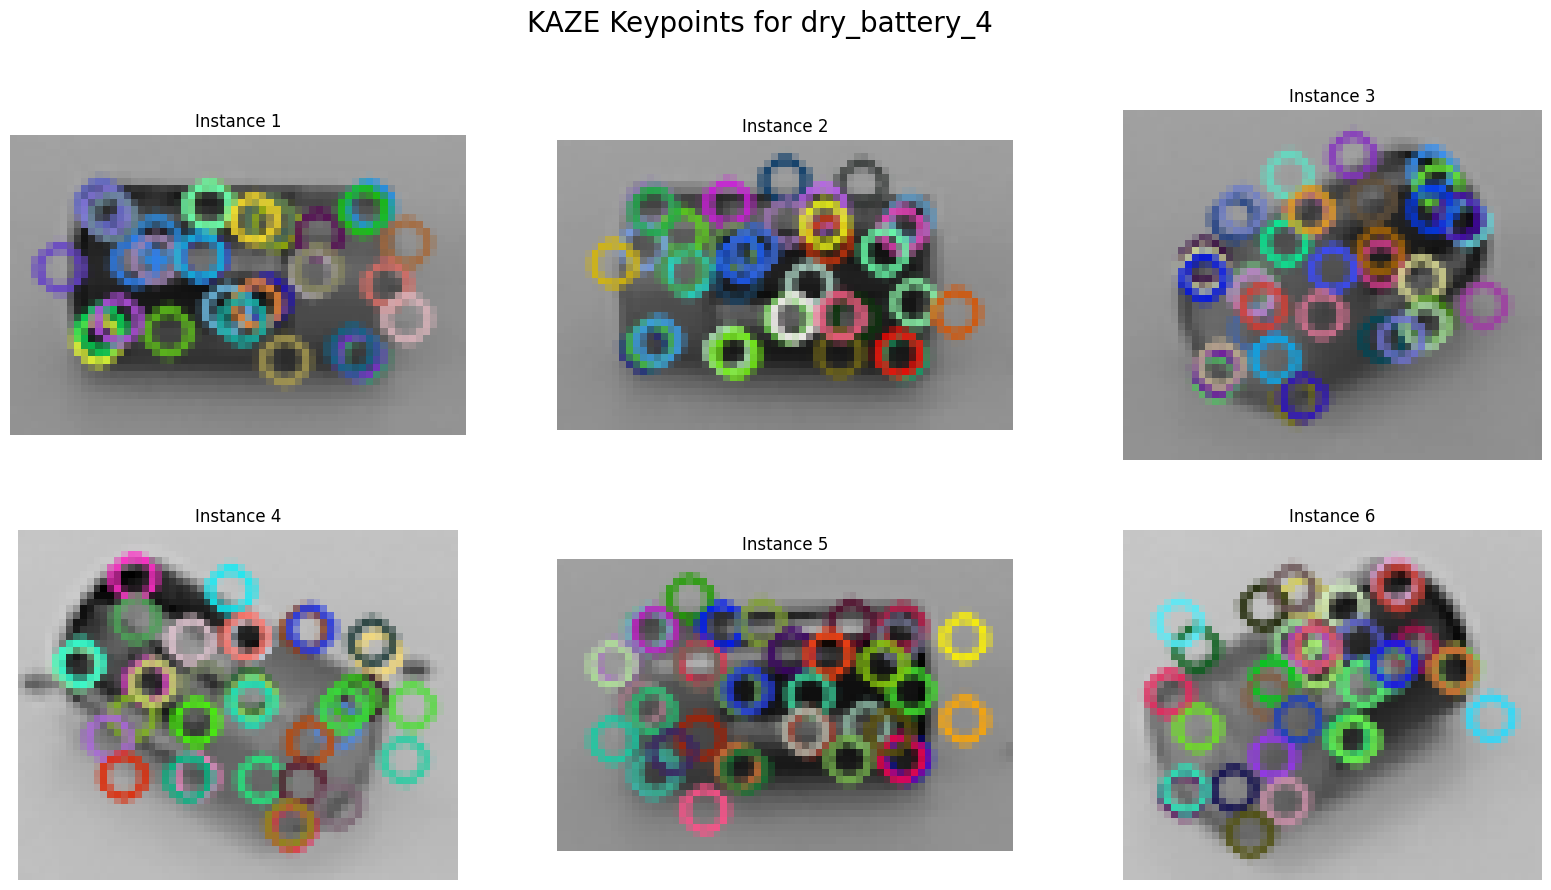

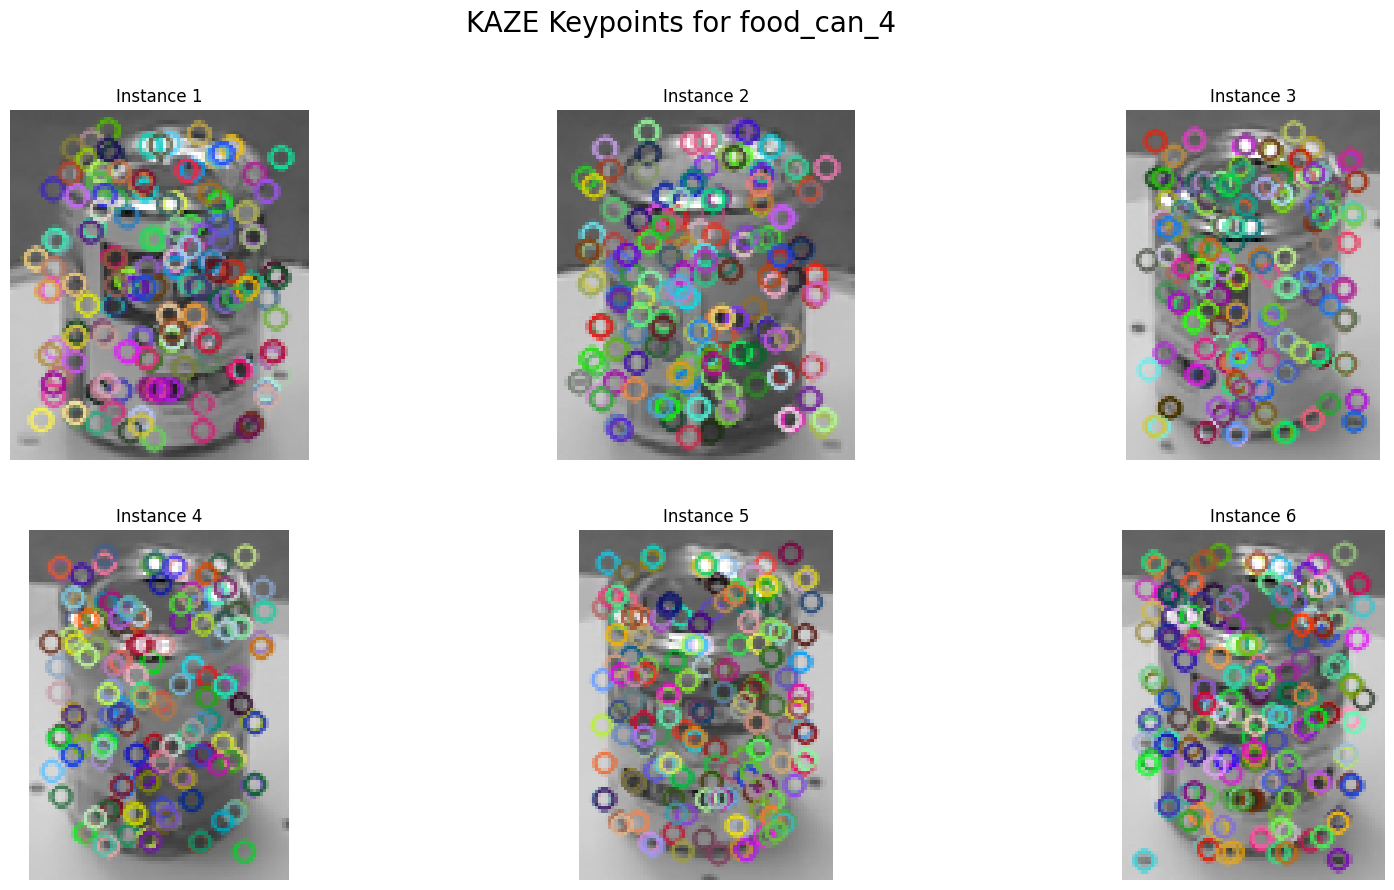

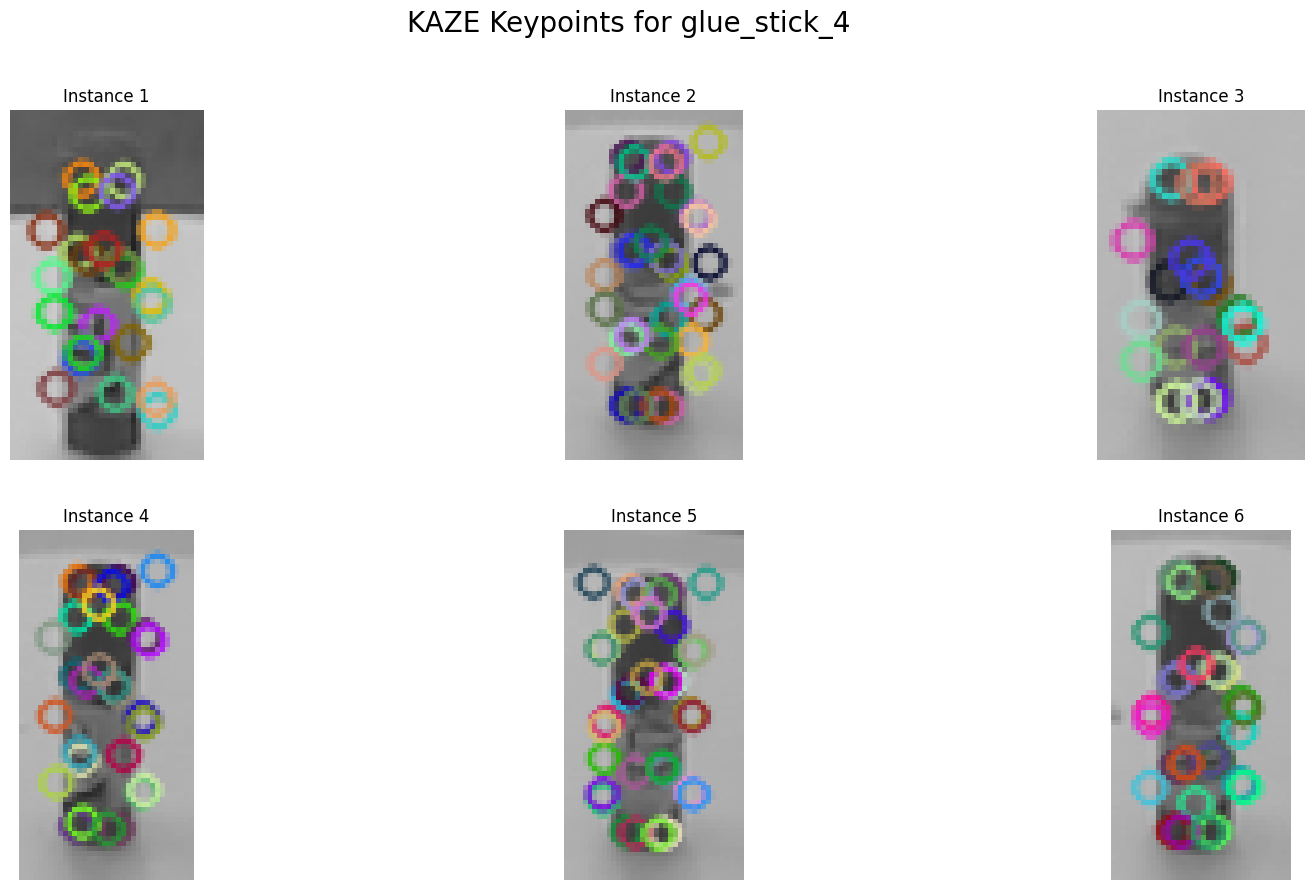

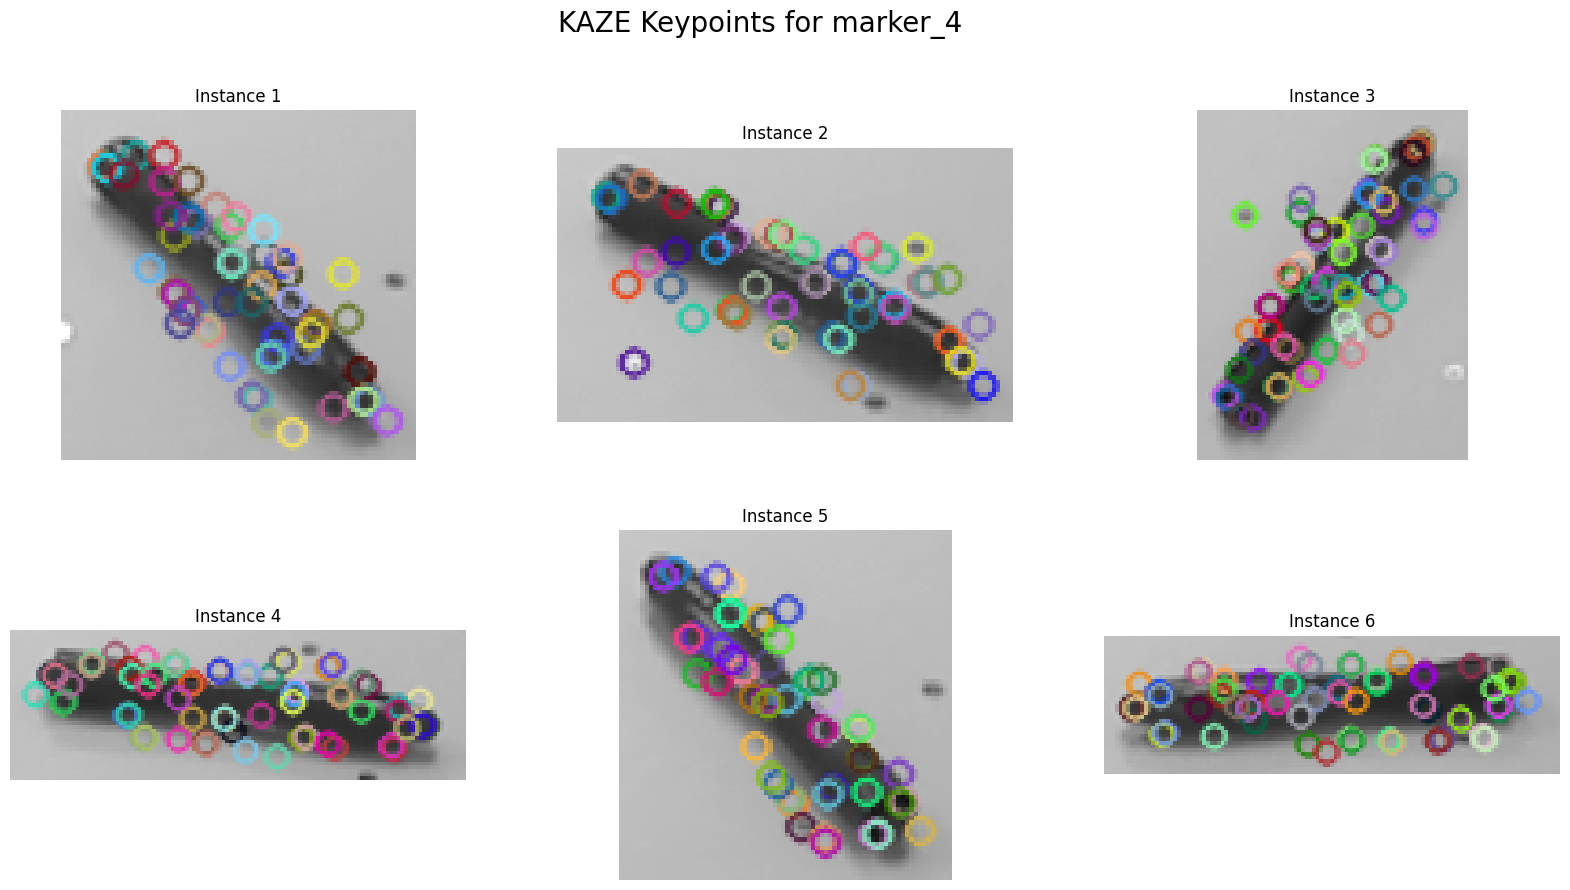

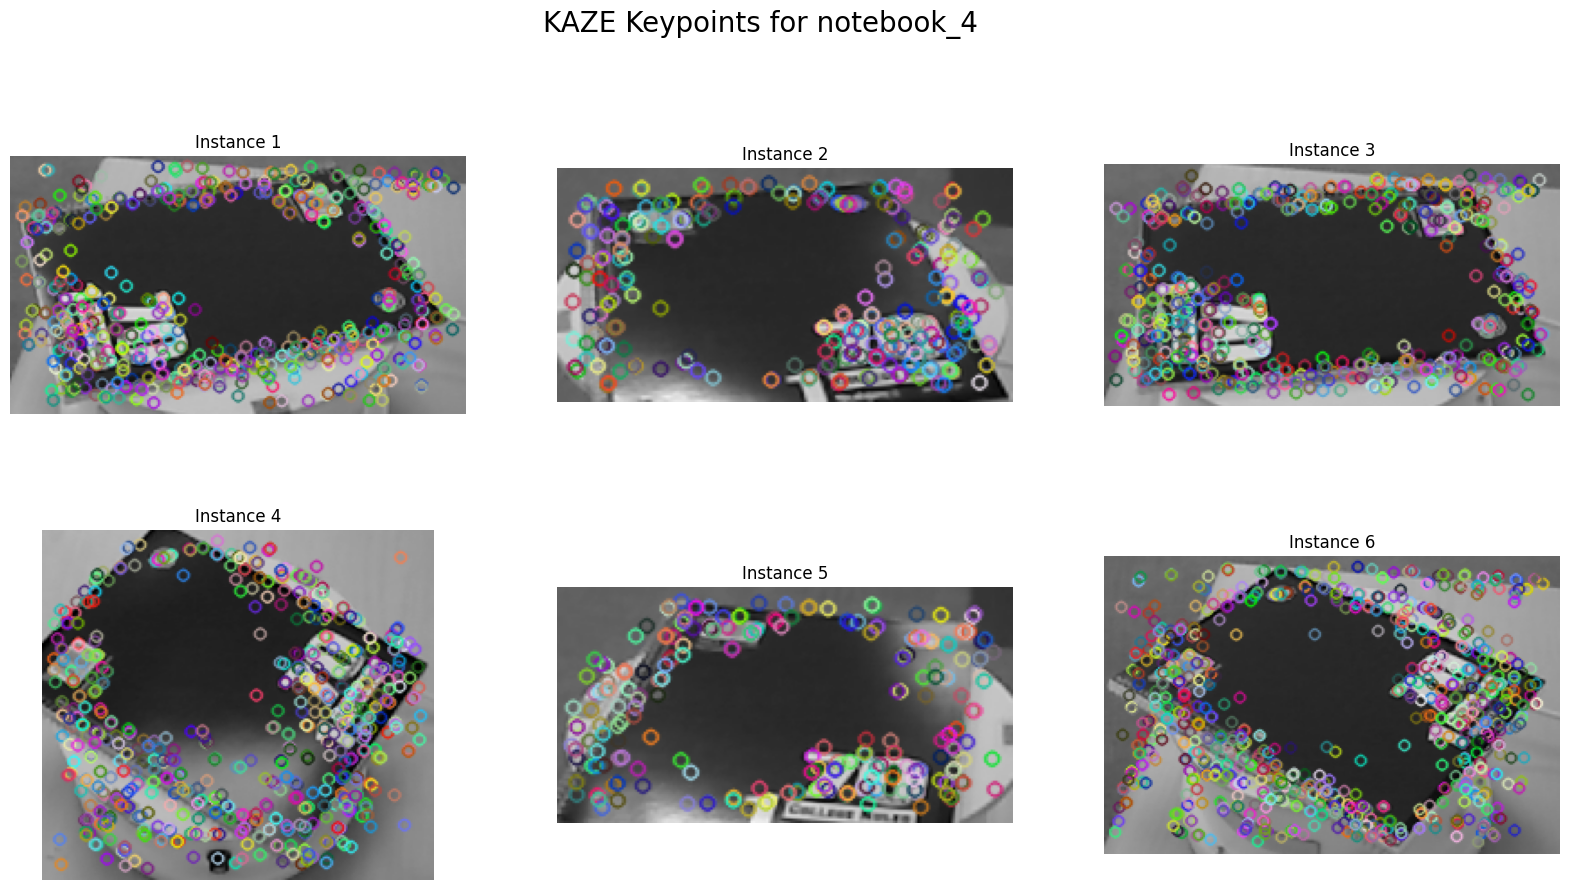

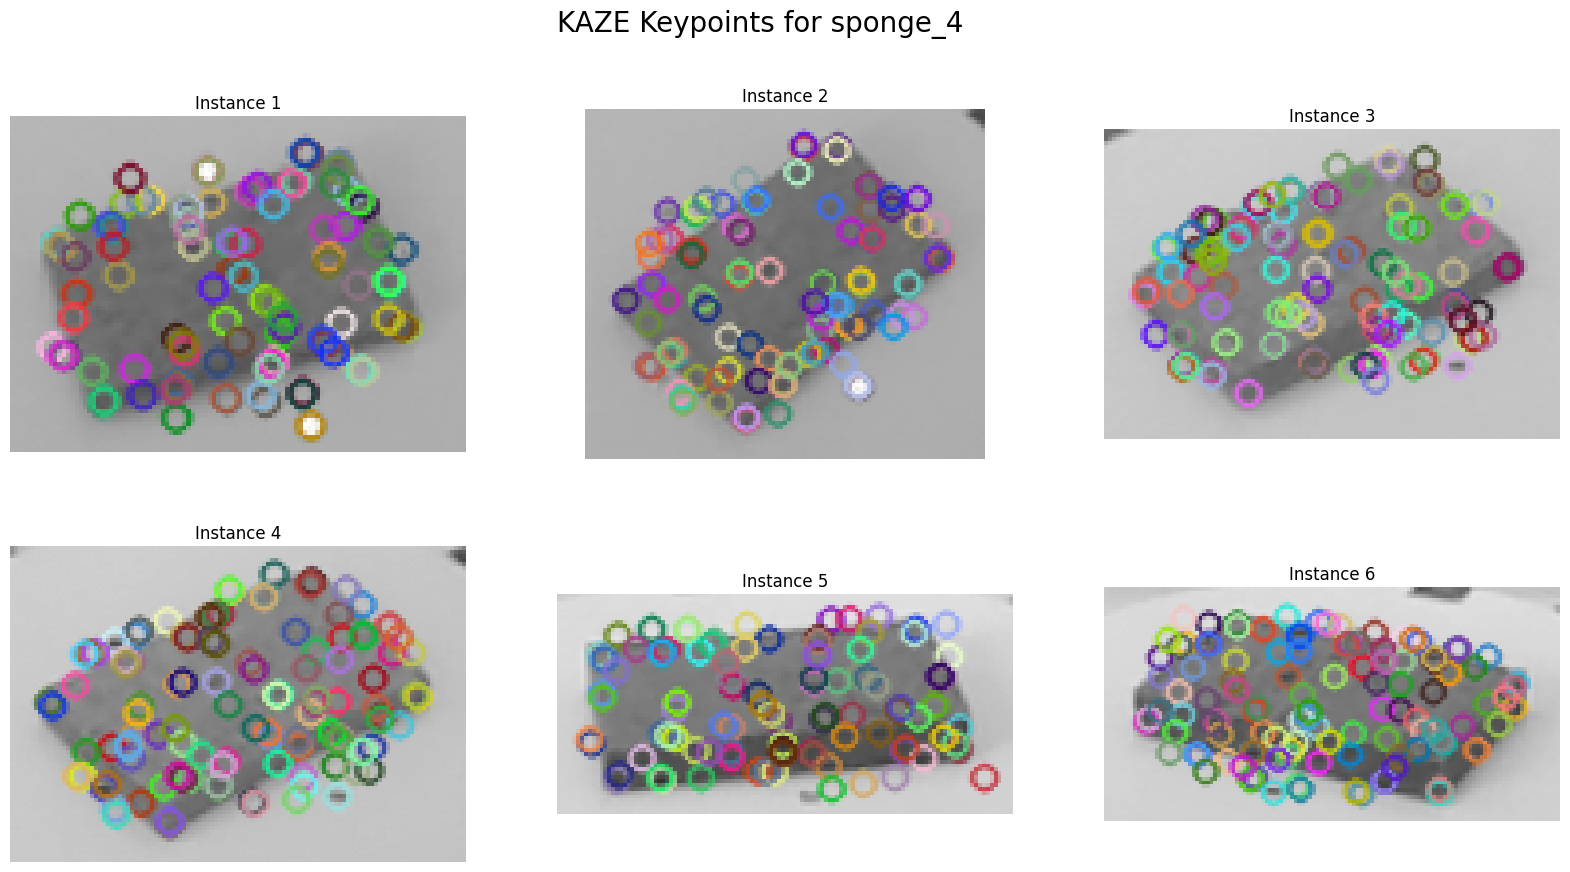

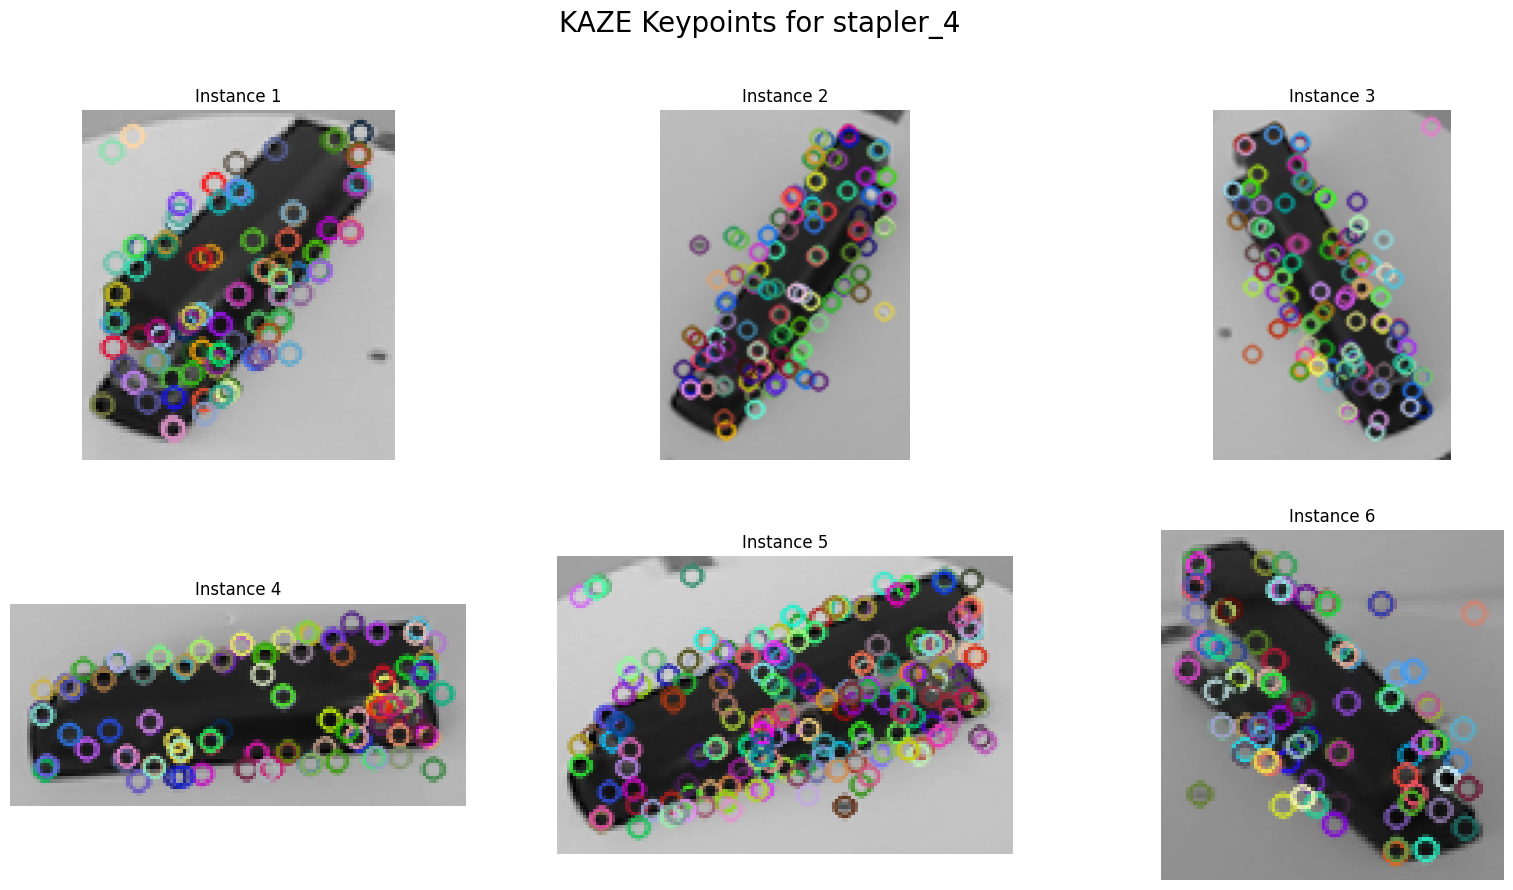

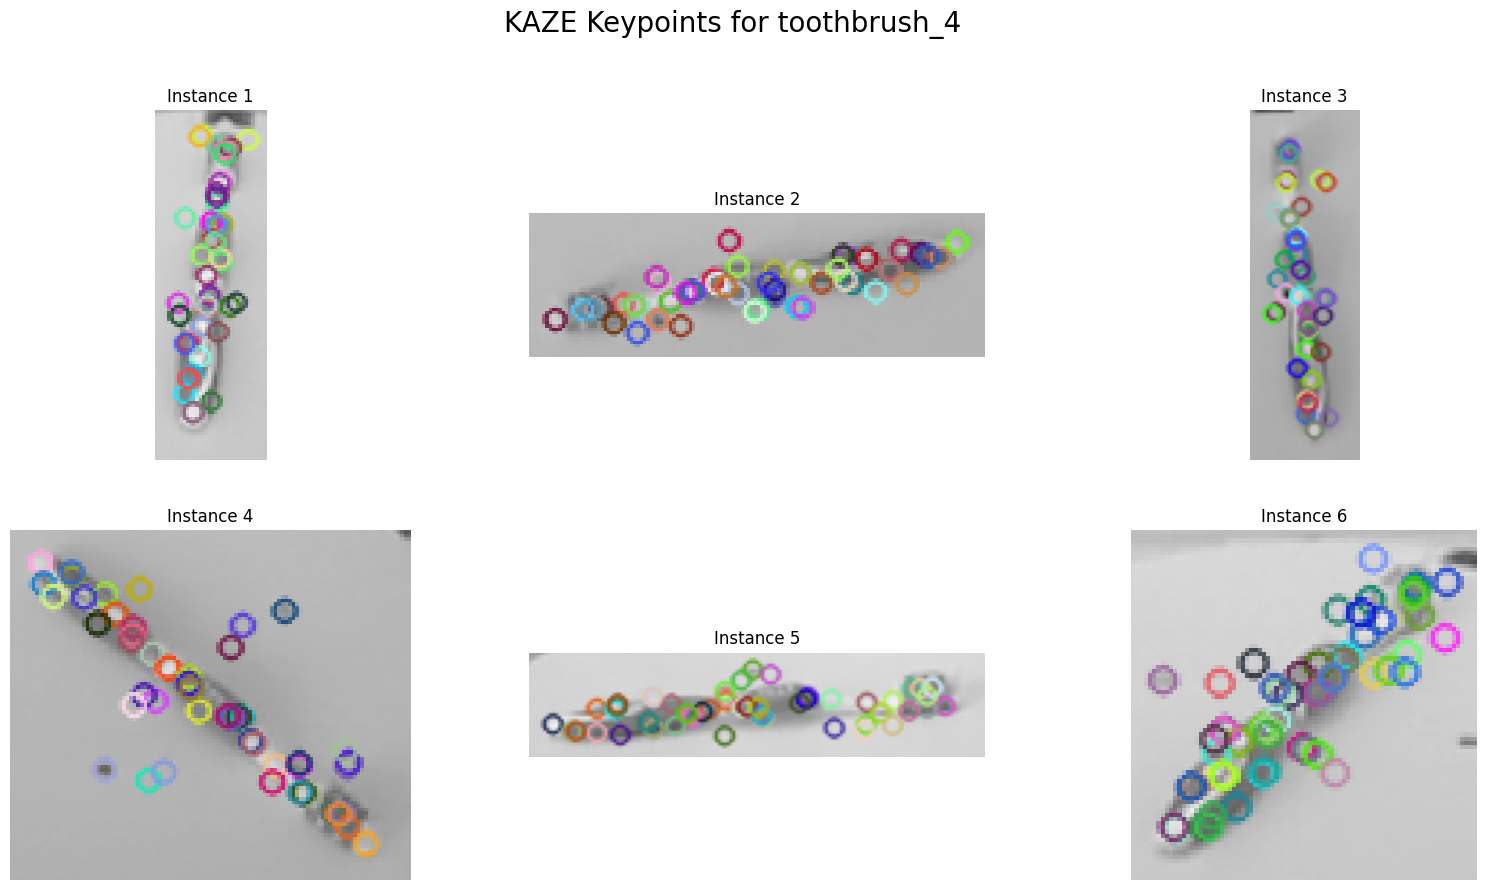

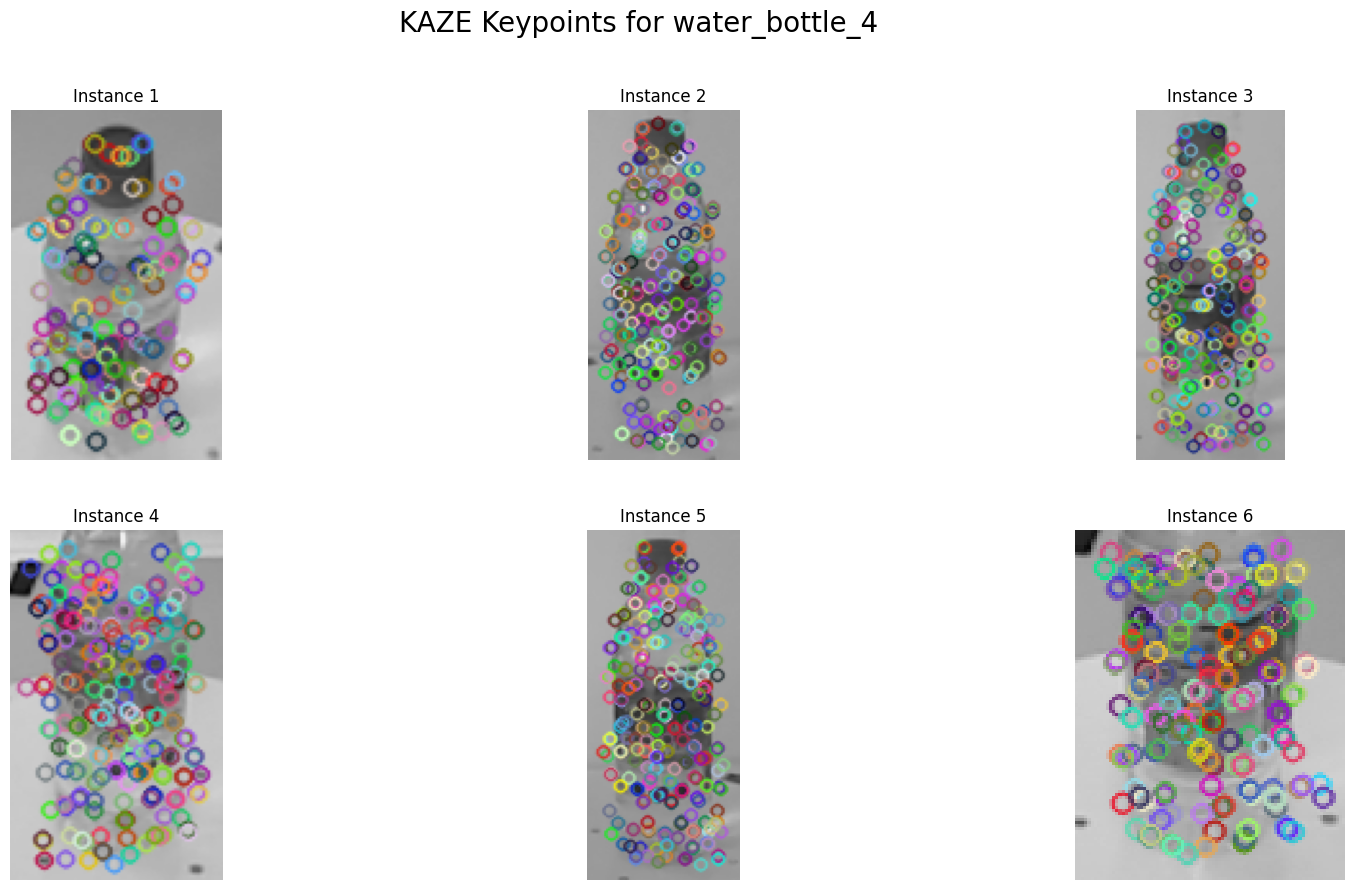

In [45]:
train_with_kaze(dataset_train, dataset_test)
